# Weather Data Collection

In [1]:
# Using NCEI API
import requests
def make_request(endpoint, payload=None):
    """
    Make a request to a specific endpoint on the weather API
    passing headers and optional payload.
    Parameters:
    - endpoint: The endpoint of the API you want to make a GET request to.
    - payload: A dictionary of data to pass along with the request.
    Returns:
    Response object.
    """
    return requests.get(
        f'https://www.ncdc.noaa.gov/cdo-web/api/v2/{endpoint}',
        headers={'token': 'ySuxEULOItJCFagAXLrMNmpvZPGhEsTL'},
        params=payload)

Collect all data points for 2018 in NYC

In [2]:
# Make a loop to query all datapoints
import datetime
from IPython import display # For updating the cell

current = datetime.date(2018, 1, 1)
end = datetime.date(2019, 1, 1)
results = []
response = make_request('data',
                            {'datasetid' : 'GHCND', # Global Historical Climatology Network - Daily (GHCND) dataset
                             'locationid' : 'CITY:US360019', # NYC
                             'startdate' : current,
                             'enddate' : current,
                             'units' : 'metric',
                             'limit' : 1000 # max allowed
                            }
                             )
if response.ok: # we extend the list instead of appending to avoid getting a nested list
    while current < end:
        # update the cell with status information
        display.clear_output(wait=True)
        display.display(f'Gathering data for {str(current)}')
        results.extend(response.json()['results'])
        # update the current date to avoid an infinite loop
        current += datetime.timedelta(days=1)

'Gathering data for 2018-12-31'

In [3]:
# I modified the code above to not send requests in a loop
# I did this because the request takes a lot of time

In [4]:
# Create a dataframe with the acquired data
import pandas as pd
df = pd.DataFrame(results)
df.head()

,date,datatype,station,attributes,value
0,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
1,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0
2,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0
3,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0
4,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0


In [5]:
# Save to a csv file
df.to_csv('data/nyc_weather_2018.csv', index = False)

In [6]:
# Write to database
import sqlite3

In [7]:
with sqlite3.connect('data/weather.db') as connection:
    df.to_sql('weather', connection, index=False, if_exists='replace')

In [8]:
# Additionally, get the mapping station ID information
response = make_request('stations',{
    'datasetid' : 'GHCND', # Global Historical Climatology Network - Daily (GHCND) dataset
    'locationid' : 'CITY:US360019', # NYC
    'limit' : 1000 # max allowed
})

In [9]:
stations = pd.DataFrame(response.json()['results'])[['id', 'name', 'latitude', 'longitude', 'elevation']]
stations.to_csv('data/weather_stations.csv', index=False)

In [10]:
# Write to database
with sqlite3.connect('data/weather.db') as connection:
    stations.to_sql('stations', connection, index=False, if_exists='replace')

# Querying and Merging

In [11]:
import pandas as pd

In [12]:
# Take the saved csv
weather = pd.read_csv('nyc_weather_2018.csv')
weather.head()

,date,datatype,station,attributes,value
0,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
1,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0
2,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0
3,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0
4,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0


In [13]:
# Querying
# This is a simple way of filtering based on criteria
snow_data = weather.query('datatype == "SNOW" and value > 0') # Find entries with snow
snow_data.head()

,date,datatype,station,attributes,value
127,2018-01-01T00:00:00,SNOW,GHCND:US1NYWC0019,",,N,1700",25.0
396,2018-01-01T00:00:00,SNOW,GHCND:US1NYWC0019,",,N,1700",25.0
665,2018-01-01T00:00:00,SNOW,GHCND:US1NYWC0019,",,N,1700",25.0
934,2018-01-01T00:00:00,SNOW,GHCND:US1NYWC0019,",,N,1700",25.0
1203,2018-01-01T00:00:00,SNOW,GHCND:US1NYWC0019,",,N,1700",25.0


In [14]:
# This is similar to SELECT * FROM weather WHERE datatype == "SNOW" AND value > 0;
import sqlite3

with sqlite3.connect('data/weather.db') as connection:
    snow_data_from_db = pd.read_sql(
        'SELECT * FROM weather WHERE datatype == "SNOW" AND value > 0',
        connection)

snow_data.reset_index().drop(columns='index').equals(snow_data_from_db)

True

In [15]:
# This is also equivalent to boolean masks:
weather[(weather.datatype == 'SNOW') & (weather.value > 0)].equals(snow_data)

True

In [16]:
# Merging data frames
# Let's merge the weather_stations and nyc weather data

In [17]:
# Get the weather station data
station_info = pd.read_csv('data/weather_stations.csv')
station_info.head()

,id,name,latitude,longitude,elevation
0,GHCND:US1CTFR0022,"STAMFORD 2.6 SSW, CT US",41.064100,-73.577000,36.6
1,GHCND:US1CTFR0039,"STAMFORD 4.2 S, CT US",41.037788,-73.568176,6.4
2,GHCND:US1NJBG0001,"BERGENFIELD 0.3 SW, NJ US",40.921298,-74.001983,20.1
3,GHCND:US1NJBG0002,"SADDLE BROOK TWP 0.6 E, NJ US",40.902694,-74.083358,16.8
4,GHCND:US1NJBG0003,"TENAFLY 1.3 W, NJ US",40.914670,-73.977500,21.6


In [18]:
# Before merging dataframes, make sure to check if both are compatible for meging
station_info.id.describe() # Check for unique values in the id column

count                   330
unique                  330
top       GHCND:USW00094789
freq                      1
Name: id, dtype: object

In [19]:
weather.station.describe() # Check for unique values in the station column
# The output says that the weather dataframe has many entries per station

count                 98185
unique                   73
top       GHCND:USW00014732
freq                   6570
Name: station, dtype: object

In [20]:
# Check for number of rows
# It's best to put this in a function because we have to check for it frequently
def get_row_count(*dfs): # * means we can place many arguments
    return [i.shape[0] for i in dfs] # Remember to use brackets for list comprehension

In [21]:
get_row_count(weather, station_info)

[98185, 330]

In [22]:
# Alternatively, we can use the map() function as it is more efficient than list comprehension
def get_info(attr, *dfs): # attr refers to the function we want to execute
    return list(map(lambda x: getattr(x, attr), dfs))

In [23]:
get_info('shape', station_info, weather)

[(330, 5), (98185, 5)]

In [24]:
get_info('columns', station_info, weather)

[Index(['id', 'name', 'latitude', 'longitude', 'elevation'], dtype='object'),
 Index(['date', 'datatype', 'station', 'attributes', 'value'], dtype='object')]

In [25]:
# By default, merge() performs an inner join. We simply specify the columns to use for join.
# The left dataframe is the one that we call the merge() on
# The right dataframe is passed in as an argument
inner_join = weather.merge(station_info, left_on='station', right_on='id')
inner_join.sample(5, random_state=0)

,date,datatype,station,attributes,value,id,name,latitude,longitude,elevation
41068,2018-01-01T00:00:00,ADPT,GHCND:USW00014734,",,W,",-194.0,GHCND:USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",40.682750,-74.169270,1.9
7886,2018-01-01T00:00:00,PRCP,GHCND:US1NYNS0007,",,N,0700",0.0,GHCND:US1NYNS0007,"FLORAL PARK 0.4 W, NY US",40.723000,-73.710999,24.1
89184,2018-01-01T00:00:00,TOBS,GHCND:USC00283704,",,7,0700",-15.0,GHCND:USC00283704,"HARRISON, NJ US",40.748100,-74.152000,7.3
49053,2018-01-01T00:00:00,SNOW,GHCND:US1NYNS0035,",,N,1700",0.0,GHCND:US1NYNS0035,"VALLEY STREAM 0.6 SE, NY US",40.657136,-73.697830,3.7
68870,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0018,",,N,0900",0.0,GHCND:US1NJBG0018,"PALISADES PARK 0.2 WNW, NJ US",40.848094,-74.000247,21.3


In [26]:
# We can remove the two columns with the same value by renaming one of them before the merge
# Note that this works because we changed one of the columns to match each other's name to 'station'
station_renamed = station_info.rename(columns = {'id': 'station'})
weather.merge(station_renamed, on='station').head()

,date,datatype,station,attributes,value,name,latitude,longitude,elevation
0,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0,"STAMFORD 4.2 S, CT US",41.037788,-73.568176,6.4
1,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0,"NORTH ARLINGTON 0.7 WNW, NJ US",40.791492,-74.139790,17.7
2,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0,"NORTH ARLINGTON 0.7 WNW, NJ US",40.791492,-74.139790,17.7
3,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0,"GLEN ROCK 0.7 SSE, NJ US",40.951090,-74.118264,28.0
4,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0,"GLEN ROCK 0.7 SSE, NJ US",40.951090,-74.118264,28.0


In [27]:
# We can also do the same with this syntax
weather.merge(station_info.rename(dict(id='station'), axis=1), on='station').head()

,date,datatype,station,attributes,value,name,latitude,longitude,elevation
0,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0,"STAMFORD 4.2 S, CT US",41.037788,-73.568176,6.4
1,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0,"NORTH ARLINGTON 0.7 WNW, NJ US",40.791492,-74.139790,17.7
2,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0,"NORTH ARLINGTON 0.7 WNW, NJ US",40.791492,-74.139790,17.7
3,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0,"GLEN ROCK 0.7 SSE, NJ US",40.951090,-74.118264,28.0
4,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0,"GLEN ROCK 0.7 SSE, NJ US",40.951090,-74.118264,28.0


In [28]:
# In using inner join, we are losing a row that doesn't have an association with another row
# This means a unique id of one table isn't present in the other table
# If we don't want to lose them, we perform a left or right join
# Doing this will keep all of the values of the rows regardless if there is no weather observations
left_join = station_info.merge(weather, left_on='id', right_on='station', how='left')
right_join = weather.merge(station_info, left_on='station', right_on='id', how='right')

In [29]:
left_join.head()

,id,name,latitude,longitude,elevation,date,datatype,station,attributes,value
0,GHCND:US1CTFR0022,"STAMFORD 2.6 SSW, CT US",41.064100,-73.577000,36.6,NaN,NaN,NaN,NaN,NaN
1,GHCND:US1CTFR0039,"STAMFORD 4.2 S, CT US",41.037788,-73.568176,6.4,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
2,GHCND:US1CTFR0039,"STAMFORD 4.2 S, CT US",41.037788,-73.568176,6.4,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
3,GHCND:US1CTFR0039,"STAMFORD 4.2 S, CT US",41.037788,-73.568176,6.4,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
4,GHCND:US1CTFR0039,"STAMFORD 4.2 S, CT US",41.037788,-73.568176,6.4,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0


In [30]:
right_join.head()

,date,datatype,station,attributes,value,id,name,latitude,longitude,elevation
0,NaN,NaN,NaN,NaN,NaN,GHCND:US1CTFR0022,"STAMFORD 2.6 SSW, CT US",41.064100,-73.577000,36.6
1,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0,GHCND:US1CTFR0039,"STAMFORD 4.2 S, CT US",41.037788,-73.568176,6.4
2,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0,GHCND:US1CTFR0039,"STAMFORD 4.2 S, CT US",41.037788,-73.568176,6.4
3,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0,GHCND:US1CTFR0039,"STAMFORD 4.2 S, CT US",41.037788,-73.568176,6.4
4,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0,GHCND:US1CTFR0039,"STAMFORD 4.2 S, CT US",41.037788,-73.568176,6.4


In [31]:
# The left and right join we did have equivalent outputs
# This is because the that we kept the rows without matches are the same

In [32]:
# Notice the difference in the number of rows between the inner join and left/right join
get_info('shape', inner_join, left_join, right_join)

[(98185, 10), (98442, 10), (98442, 10)]

In [33]:
# We can check where the mismatches occur
# To do this we query the station information that have NY in their name
# Then perform an outer join
outer_join = weather.merge(station_info[station_info.name.str.contains('NY')],
                           left_on='station', right_on='id', how='outer', indicator=True)

outer_join.sample(4, random_state=0)

,date,datatype,station,attributes,value,id,name,latitude,longitude,elevation,_merge
10711,2018-01-01T00:00:00,PRCP,GHCND:US1NJMD0066,",,N,0900",0.0,NaN,NaN,NaN,NaN,NaN,left_only
16766,2018-01-01T00:00:00,SNOW,GHCND:US1NJMS0011,",,N,0700",0.0,NaN,NaN,NaN,NaN,NaN,left_only
59544,2018-01-01T00:00:00,ASTP,GHCND:USW00014732,",,W,",10264.0,GHCND:USW00014732,"LAGUARDIA AIRPORT, NY US",40.77945,-73.88027,3.0,both
8036,2018-01-01T00:00:00,SNOW,GHCND:US1NJMD0043,",,N,0700",0.0,NaN,NaN,NaN,NaN,NaN,left_only


In [34]:
# These joins are equivalent to their sql counterparts.
# Note that to use equals(), we have to manipulate the dataframe to line them up
with sqlite3.connect('data/weather.db') as connection:
    inner_join_from_db = pd.read_sql(
        'SELECT * FROM weather JOIN stations ON weather.station == stations.id',
        connection)
inner_join_from_db.shape == inner_join.shape

True

Revisit the dirty data from the previous module

In [35]:
dirty_data = pd.read_csv(
    'data/dirty_data.csv', index_col='date'
).drop_duplicates().drop(columns='SNWD')

In [36]:
dirty_data.head()

,station,PRCP,SNOW,TMAX,TMIN,TOBS,WESF,inclement_weather
date,,,,,,,,
2018-01-01T00:00:00,?,0.0,0.0,5505.0,-40.0,NaN,NaN,NaN
2018-01-02T00:00:00,GHCND:USC00280907,0.0,0.0,-8.3,-16.1,-12.2,NaN,False
2018-01-03T00:00:00,GHCND:USC00280907,0.0,0.0,-4.4,-13.9,-13.3,NaN,False
2018-01-04T00:00:00,?,20.6,229.0,5505.0,-40.0,NaN,19.3,True
2018-01-05T00:00:00,?,0.3,NaN,5505.0,-40.0,NaN,NaN,NaN


In [37]:
# We need to create two dataframes for the join. 
# We will drop some unecessary columns as well for easier viewing:
valid_station = dirty_data.query('station != "?"').copy().drop(columns=['WESF', 'station'])
station_with_wesf = dirty_data.query('station == "?"').copy().drop(columns=['station', 'TOBS', 'TMIN', 'TMAX'])

In [38]:
# Our column for the join is the index in both dataframes, 
# so we must specify left_index and right_index
valid_station.merge(station_with_wesf, left_index=True, right_index=True).query('WESF > 0').head()

,PRCP_x,SNOW_x,TMAX,TMIN,TOBS,inclement_weather_x,PRCP_y,SNOW_y,WESF,inclement_weather_y
date,,,,,,,,,,
2018-01-30T00:00:00,0.0,0.0,6.7,-1.7,-0.6,False,1.5,13.0,1.8,True
2018-03-08T00:00:00,48.8,NaN,1.1,-0.6,1.1,False,28.4,NaN,28.7,NaN
2018-03-13T00:00:00,4.1,51.0,5.6,-3.9,0.0,True,3.0,13.0,3.0,True
2018-03-21T00:00:00,0.0,0.0,2.8,-2.8,0.6,False,6.6,114.0,8.6,True
2018-04-02T00:00:00,9.1,127.0,12.8,-1.1,-1.1,True,14.0,152.0,15.2,True


In [39]:
# The columns that existed in both dataframes, but didn't form part of the join got suffixes added to their names: 
# _x for columns from the left dataframe and _y for columns from the right dataframe.
# We can customize this with the suffixes argument:
valid_station.merge(station_with_wesf, left_index=True, right_index=True, suffixes=('', '_?')).query('WESF > 0').head()

,PRCP,SNOW,TMAX,TMIN,TOBS,inclement_weather,PRCP_?,SNOW_?,WESF,inclement_weather_?
date,,,,,,,,,,
2018-01-30T00:00:00,0.0,0.0,6.7,-1.7,-0.6,False,1.5,13.0,1.8,True
2018-03-08T00:00:00,48.8,NaN,1.1,-0.6,1.1,False,28.4,NaN,28.7,NaN
2018-03-13T00:00:00,4.1,51.0,5.6,-3.9,0.0,True,3.0,13.0,3.0,True
2018-03-21T00:00:00,0.0,0.0,2.8,-2.8,0.6,False,6.6,114.0,8.6,True
2018-04-02T00:00:00,9.1,127.0,12.8,-1.1,-1.1,True,14.0,152.0,15.2,True


In [40]:
# Since we are joining on the index, an easier way is to use the join() method instead of merge() . 
# Note that the suffix parameter is now lsuffix for the left dataframe's suffix and rsuffix for the right one's
valid_station.join(station_with_wesf, rsuffix='_?').query('WESF > 0').head()

,PRCP,SNOW,TMAX,TMIN,TOBS,inclement_weather,PRCP_?,SNOW_?,WESF,inclement_weather_?
date,,,,,,,,,,
2018-01-30T00:00:00,0.0,0.0,6.7,-1.7,-0.6,False,1.5,13.0,1.8,True
2018-03-08T00:00:00,48.8,NaN,1.1,-0.6,1.1,False,28.4,NaN,28.7,NaN
2018-03-13T00:00:00,4.1,51.0,5.6,-3.9,0.0,True,3.0,13.0,3.0,True
2018-03-21T00:00:00,0.0,0.0,2.8,-2.8,0.6,False,6.6,114.0,8.6,True
2018-04-02T00:00:00,9.1,127.0,12.8,-1.1,-1.1,True,14.0,152.0,15.2,True


In [41]:
# Joins can be very resource-intensive, so it's a good idea to figure out what type of join you need. 
# The pandas set operations are performed on the index,
# so whichever columns we will be joining on will need to be the index

In [42]:
# Let's go back to the weather and station_info dataframes and set the station ID columns as the index:
weather.set_index('station', inplace=True)
station_info.set_index('id', inplace=True)

In [43]:
# The intersection will tell us the stations that are present in both dataframes. 
#The result will be the index when performing an inner join:
weather.index.intersection(station_info.index)

Index(['GHCND:US1CTFR0039', 'GHCND:US1NJBG0015', 'GHCND:US1NJBG0017',
       'GHCND:US1NJBG0018', 'GHCND:US1NJBG0023', 'GHCND:US1NJBG0030',
       'GHCND:US1NJBG0039', 'GHCND:US1NJBG0044', 'GHCND:US1NJES0018',
       'GHCND:US1NJES0024', 'GHCND:US1NJMD0043', 'GHCND:US1NJMD0045',
       'GHCND:US1NJMD0062', 'GHCND:US1NJMD0066', 'GHCND:US1NJMD0070',
       'GHCND:US1NJMD0073', 'GHCND:US1NJMD0074', 'GHCND:US1NJMN0010',
       'GHCND:US1NJMN0012', 'GHCND:US1NJMN0048', 'GHCND:US1NJMN0069',
       'GHCND:US1NJMN0104', 'GHCND:US1NJMS0011', 'GHCND:US1NJMS0040',
       'GHCND:US1NJMS0049', 'GHCND:US1NJMS0059', 'GHCND:US1NJMS0089',
       'GHCND:US1NJPS0005', 'GHCND:US1NJPS0012', 'GHCND:US1NJPS0014',
       'GHCND:US1NJPS0022', 'GHCND:US1NJPS0025', 'GHCND:US1NJUN0003',
       'GHCND:US1NJUN0010', 'GHCND:US1NJUN0014', 'GHCND:US1NJUN0017',
       'GHCND:US1NYKN0025', 'GHCND:US1NYNS0007', 'GHCND:US1NYNS0014',
       'GHCND:US1NYNS0024', 'GHCND:US1NYNS0027', 'GHCND:US1NYNS0030',
       'GHCND:US1NYN

In [44]:
# The set difference will tell us what we lose from each side. 
# When performing an inner join, we lose nothing from the weather dataframe:
weather.index.difference(station_info.index)

Index([], dtype='object')

In [45]:
# We lose 153 stations from the station_info dataframe, however:
station_info.index.difference(weather.index)
# I think 257 now?

Index(['GHCND:US1CTFR0022', 'GHCND:US1NJBG0001', 'GHCND:US1NJBG0002',
       'GHCND:US1NJBG0003', 'GHCND:US1NJBG0005', 'GHCND:US1NJBG0006',
       'GHCND:US1NJBG0008', 'GHCND:US1NJBG0010', 'GHCND:US1NJBG0011',
       'GHCND:US1NJBG0012',
       ...
       'GHCND:USC00308749', 'GHCND:USC00308946', 'GHCND:USC00309117',
       'GHCND:USC00309270', 'GHCND:USC00309400', 'GHCND:USC00309466',
       'GHCND:USC00309576', 'GHCND:USC00309580', 'GHCND:USW00014708',
       'GHCND:USW00014786'],
      dtype='object', length=257)

In [46]:
# The symmetric difference will tell us what gets lost from both sides. 
# It is the combination of the set difference in both directions:
ny_in_name = station_info[station_info.name.str.contains('NY')]

ny_in_name.index.difference(weather.index).shape[0]\
+ weather.index.difference(ny_in_name.index).shape[0]\
== weather.index.symmetric_difference(ny_in_name.index).shape[0]

True

In [47]:
# The union will show us everything that will be present after a full outer join. 
#Note that since these are sets (which don't allow duplicates by definition), we must pass unique entries for union:
weather.index.unique().union(station_info.index)

Index(['GHCND:US1CTFR0022', 'GHCND:US1CTFR0039', 'GHCND:US1NJBG0001',
       'GHCND:US1NJBG0002', 'GHCND:US1NJBG0003', 'GHCND:US1NJBG0005',
       'GHCND:US1NJBG0006', 'GHCND:US1NJBG0008', 'GHCND:US1NJBG0010',
       'GHCND:US1NJBG0011',
       ...
       'GHCND:USW00014708', 'GHCND:USW00014732', 'GHCND:USW00014734',
       'GHCND:USW00014786', 'GHCND:USW00054743', 'GHCND:USW00054787',
       'GHCND:USW00094728', 'GHCND:USW00094741', 'GHCND:USW00094745',
       'GHCND:USW00094789'],
      dtype='object', length=330)

In [48]:
# Note that the symmetric difference is actually the union of the set differences:
ny_in_name = station_info[station_info.name.str.contains('NY')] 
ny_in_name.index.difference(weather.index).union(weather.index.difference(ny_in_name.index)).equals(
    weather.index.symmetric_difference(ny_in_name.index))

True

# Dataframe Operations

In [58]:
import numpy as np
import pandas as pd

weather = pd.read_csv('HOA8_nyc_weather_2018.csv', parse_dates=['date'])
weather.head()

,attributes,datatype,date,station,value
0,",,N,",PRCP,2018-01-01,GHCND:US1CTFR0039,0.0
1,",,N,",PRCP,2018-01-01,GHCND:US1NJBG0015,0.0
2,",,N,",SNOW,2018-01-01,GHCND:US1NJBG0015,0.0
3,",,N,",PRCP,2018-01-01,GHCND:US1NJBG0017,0.0
4,",,N,",SNOW,2018-01-01,GHCND:US1NJBG0017,0.0


In [59]:
fb = pd.read_csv('data/fb_2018.csv', index_col='date', parse_dates=True)
fb.head()

,open,high,low,close,volume
date,,,,,
2018-01-02,177.68,181.58,177.5500,181.42,18151903
2018-01-03,181.88,184.78,181.3300,184.67,16886563
2018-01-04,184.90,186.21,184.0996,184.33,13880896
2018-01-05,185.59,186.90,184.9300,186.85,13574535
2018-01-08,187.20,188.90,186.3300,188.28,17994726


Arithmetic and statistics

In [60]:
# We can use methods, which allow us to specify the axis to perform the calculation over. 
# By default this is per column.
# Let's find the z-scores for the volume traded
# And look at the days where this was more than 3 standard deviations from the mean:
fb.assign(
    abs_z_score_volume = lambda x: x.volume.sub(x.volume.mean()).div(x.volume.std()).abs()
).query('abs_z_score_volume > 3') # Based on the formula (x − x̅ )/σ

,open,high,low,close,volume,abs_z_score_volume
date,,,,,,
2018-03-19,177.01,177.17,170.06,172.56,88140060,3.145078
2018-03-20,167.47,170.20,161.95,168.15,129851768,5.315169
2018-03-21,164.80,173.40,163.30,169.39,106598834,4.105413
2018-03-26,160.82,161.10,149.02,160.06,126116634,5.120845
2018-07-26,174.89,180.13,173.75,176.26,169803668,7.393705


In [61]:
# We can use rank() and pct_change() to see which days had the largest change in volume traded from the day before:
fb.assign(volume_pct_change = fb.volume.pct_change(),
          pct_change_rank = lambda x: x.volume_pct_change.abs().rank(ascending=False) 
         ).nsmallest(5, 'pct_change_rank')

,open,high,low,close,volume,volume_pct_change,pct_change_rank
date,,,,,,,
2018-01-12,178.06,181.48,177.40,179.37,77551299,7.087876,1.0
2018-03-19,177.01,177.17,170.06,172.56,88140060,2.611789,2.0
2018-07-26,174.89,180.13,173.75,176.26,169803668,1.628841,3.0
2018-09-21,166.64,167.25,162.81,162.93,45994800,1.428956,4.0
2018-03-26,160.82,161.10,149.02,160.06,126116634,1.352496,5.0


In [62]:
# anuary 12th was when the news that Facebook changed its news feed product to 
# focus more on content from a users' friends over the brands they follow. 
# Given that Facebook's advertising is a key component of its business (nearly 89% in 2017), 
# many shares were sold and the price dropped in panic:
fb['2018-01-11':'2018-01-12']

,open,high,low,close,volume
date,,,,,
2018-01-11,188.40,188.40,187.38,187.77,9588587
2018-01-12,178.06,181.48,177.40,179.37,77551299


In [63]:
# Throughout 2018, Facebook's stock price never had a low above $215:
(fb > 215).any()

open       True
high       True
low       False
close      True
volume     True
dtype: bool

In [64]:
# Facebook's OHLC (open, high, low, and close) prices all had at least one day they were at $215 or less:
(fb > 215).all()

open      False
high      False
low       False
close     False
volume     True
dtype: bool

Binnning and thresholds

In [65]:
# When working with the volume traded, we may be interested in ranges of volume rather than the exact values. 
# No two days have the same volume traded:
(fb.volume.value_counts() > 1).sum()

np.int64(0)

In [66]:
# We can use pd.cut() to create 3 bins of even an even range in volume traded and name them. 
# Then we can work with low, medium, and high volume traded categories:
volume_binned = pd.cut(fb.volume, bins=3, labels=['low', 'med', 'high'])
volume_binned.value_counts()

volume
low     240
med       8
high      3
Name: count, dtype: int64

In [67]:
fb[volume_binned == 'high'].sort_values('volume', ascending=False)

,open,high,low,close,volume
date,,,,,
2018-07-26,174.89,180.13,173.75,176.26,169803668
2018-03-20,167.47,170.20,161.95,168.15,129851768
2018-03-26,160.82,161.10,149.02,160.06,126116634


In [68]:
# July 25th Facebook announced disappointing user growth and the stock tanked in the after hours:
fb['2018-07-25':'2018-07-26']

,open,high,low,close,volume
date,,,,,
2018-07-25,215.715,218.62,214.27,217.50,64592585
2018-07-26,174.890,180.13,173.75,176.26,169803668


In [69]:
# Cambridge Analytica scandal broke on Saturday March 17th, so we look to the Monday for the numbers:
fb['2018-03-16':'2018-03-20']

,open,high,low,close,volume
date,,,,,
2018-03-16,184.49,185.33,183.41,185.09,24403438
2018-03-19,177.01,177.17,170.06,172.56,88140060
2018-03-20,167.47,170.20,161.95,168.15,129851768


In [70]:
# Since most days have similar volume, but a few are very large, we have very wide bins. 
# Most of the data is in the low bin.

In [71]:
import matplotlib.pyplot as plt

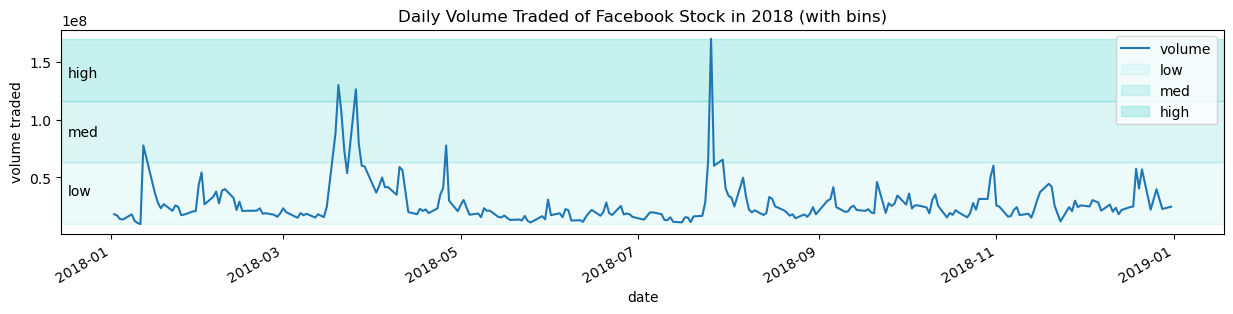

In [72]:
fb.plot(y='volume', figsize=(15, 3), title='Daily Volume Traded of Facebook Stock in 2018 (with bins)')

for bin_name, alpha, bounds in zip(
    ['low', 'med', 'high'], [0.1, 0.2, 0.3], pd.cut(fb.volume, bins=3).unique().categories.values
):
    plt.axhspan(bounds.left, bounds.right, alpha=alpha, label=bin_name, color='mediumturquoise')
    plt.annotate(bin_name, xy = ('2017-12-17', (bounds.left + bounds.right)/2.1))

plt.ylabel('volume traded')
plt.legend()
plt.show()

In [73]:
# If we split using quantiles, the bins will have roughly the same number of observations. 
#For this, we use qcut(). We will make 4 quartiles:
volume_qbinned = pd.qcut(fb.volume, q=4, labels=['q1', 'q2', 'q3', 'q4'])
volume_qbinned.value_counts()

volume
q1    63
q2    63
q4    63
q3    62
Name: count, dtype: int64

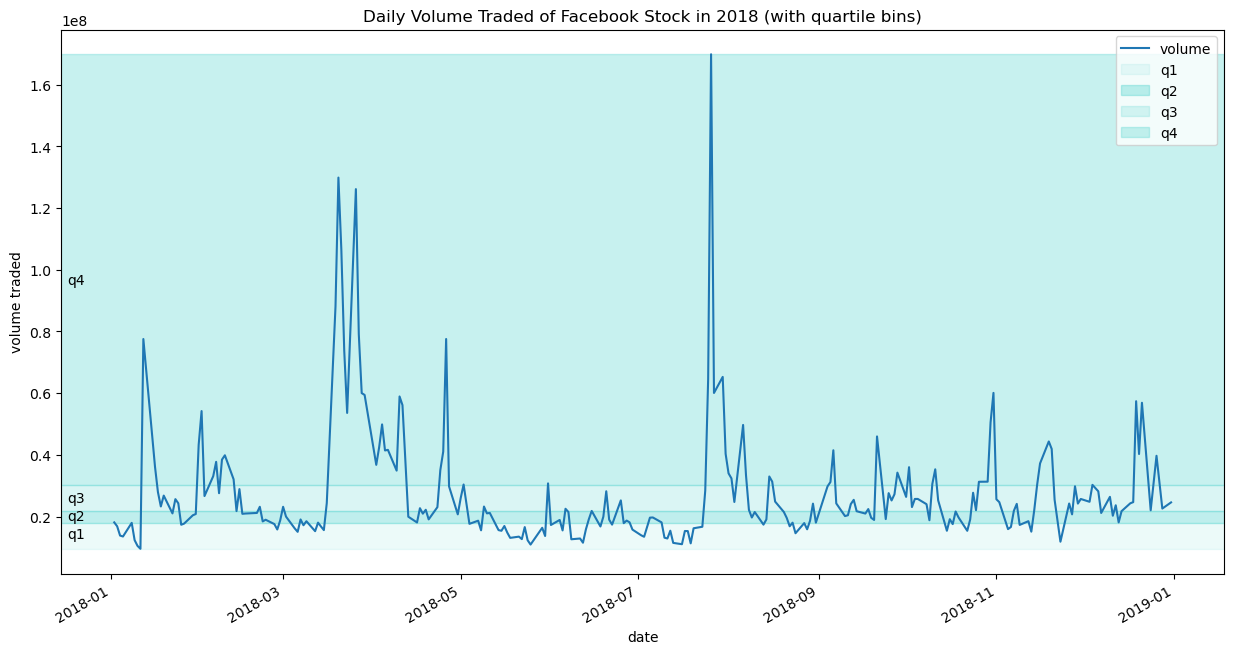

In [74]:
# Notice the bins don't cover ranges of the same size anymore:
fb.plot(y='volume', figsize=(15, 8), title='Daily Volume Traded of Facebook Stock in 2018 (with quartile bins)')

for bin_name, alpha, bounds in zip(
    ['q1', 'q2', 'q3', 'q4'], [0.1, 0.35, 0.2, 0.3], pd.qcut(fb.volume, q=4).unique().categories.values
):
    plt.axhspan(bounds.left, bounds.right, alpha=alpha, label=bin_name, color='mediumturquoise')
    plt.annotate(bin_name, xy=('2017-12-17', (bounds.left + bounds.right)/2.1))

plt.ylabel('volume traded')
plt.legend()
plt.show()

In [75]:
# Sometimes we don't want to make bins, but rather cap values at a threshold. 
# Before we look at an example, let's pivot our weather data for the Central Park station:
central_park_weather = weather.query('station == "GHCND:USW00094728"'
                                    ).pivot(index='date', columns='datatype', values='value')

In [76]:
central_park_weather.head()

datatype,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT06,WT08
date,,,,,,,,,,,,,,,
2018-01-01,3.5,0.0,0.0,0.0,-7.1,-13.8,300.0,300.0,6.7,11.2,NaN,NaN,NaN,NaN,NaN
2018-01-02,3.6,0.0,0.0,0.0,-3.2,-10.5,260.0,250.0,7.2,12.5,NaN,NaN,NaN,NaN,NaN
2018-01-03,1.4,0.0,0.0,0.0,-1.0,-8.8,260.0,270.0,6.3,9.8,NaN,NaN,NaN,NaN,NaN
2018-01-04,5.6,19.3,249.0,30.0,-1.6,-7.1,310.0,310.0,10.7,19.2,1.0,1.0,NaN,NaN,1.0
2018-01-05,5.8,0.0,0.0,180.0,-7.1,-12.7,280.0,280.0,9.4,15.7,NaN,NaN,NaN,NaN,NaN


In [77]:
# We can use clip() to replace values above a upper threshold with the threshold and replace values below a lower threshold with the lower threshold.
# This means we can use clip(0, 1) to change all the snow values of one or more to 1, which easily shows us the days snow was recorded in Central Park.
central_park_weather.SNOW.clip(0, 1).value_counts()

SNOW
0.0    354
1.0     11
Name: count, dtype: int64

Applying functions

In [78]:
# We can use the apply() method to run the same operation on all columns (or rows) of the dataframe.

In [79]:
# Calculate for z-scores of the TMIN, TMAX, and PRCIP
oct_weather_z_scores = central_park_weather.loc['2018-10', ['TMIN', 'TMAX', 'PRCP']].apply(lambda x: x.sub(x.mean()).div(x.std())) 
oct_weather_z_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
datatype,,,,,,,,
TMIN,31.0,-1.790682e-16,1.0,-1.339112,-0.751019,-0.474269,1.065152,1.843511
TMAX,31.0,1.951844e-16,1.0,-1.305582,-0.870013,-0.138258,1.011643,1.604016
PRCP,31.0,1.038596e-16,1.0,-0.394438,-0.394438,-0.394438,-0.240253,3.936167


In [80]:
# Which day rained much more than the rest of the days?
oct_weather_z_scores.query('PRCP > 3')
# October 27th rained much more than the rest of the days

datatype,TMIN,TMAX,PRCP
date,,,
2018-10-27,-0.751019,-1.201045,3.936167


In [81]:
central_park_weather.loc['2018-10', 'PRCP'].describe()

count    31.000000
mean      2.941935
std       7.458542
min       0.000000
25%       0.000000
50%       0.000000
75%       1.150000
max      32.300000
Name: PRCP, dtype: float64

In [82]:
# Tip - When the function we want to apply isn't vectorized, we can:
# use np.vectorize() to vectorize it (similar to how map() works) and then use it with apply()
# use applymap() and pass it the non-vectorized function directly

In [83]:
# Say we wanted to count the digits of the whole numbers for the Facebook data. len() is not vectorized:
import numpy as np

fb.apply(lambda x: np.vectorize(lambda y: len(str(np.ceil(y))))(x)
        ).astype('int64').equals(fb.map(lambda x: len(str(np.ceil(x))))) # .applymap has been deprecated, so I modified to .map

True

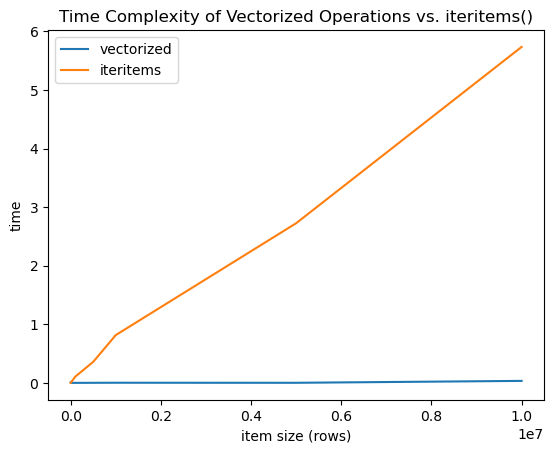

In [84]:
# A simple operation of addition to each element in a series grows linearly in time complexity when using iteritems(), 
# but stays near 0 when using vectorized operations. 
# iteritems() and related methods should only be used if there is no vectorized solution
# Side note: iteritems() was removed and now replaced by items()

import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.random.seed(0)
vectorized_results = {}
iteritems_results = {}

for size in [10, 100, 1000, 10000, 100000, 500000, 1000000, 5000000, 10000000]:
    test = pd.Series(np.random.uniform(size=size))
    
    start = time.time()
    x = test + 10
    end = time.time()
    vectorized_results[size] = end - start
    
    start = time.time()
    x = []
    for i, v in test.items(): # iteritems was replaced with items
        x.append(v + 10)
    x = pd.Series(x)
    end = time.time()
    iteritems_results[size] = end - start

pd.DataFrame([pd.Series(vectorized_results, name='vectorized'), pd.Series(iteritems_results, name='iteritems')]
).T.plot(title='Time Complexity of Vectorized Operations vs. iteritems()')
plt.xlabel('item size (rows)')
plt.ylabel('time')
plt.show()

Window calculations

In [85]:
# The rolling() method allows us to perform rolling window calculations. 
# We simply specify the window size (3 days here) and follow it with a call to an aggregation function (sum here)
central_park_weather.loc['2018-10'].assign(
    rolling_PRCP=lambda x: x.PRCP.rolling('3D').sum()
)[['PRCP', 'rolling_PRCP']].head(7).T

date,2018-10-01,2018-10-02,2018-10-03,2018-10-04,2018-10-05,2018-10-06,2018-10-07
datatype,,,,,,,
PRCP,0.0,17.5,0.0,1.0,0.0,0.0,0.0
rolling_PRCP,0.0,17.5,17.5,18.5,1.0,1.0,0.0


In [86]:
central_park_weather.loc['2018-10'].rolling('3D').mean().head(7).iloc[:,:6]

datatype,AWND,PRCP,SNOW,SNWD,TMAX,TMIN
date,,,,,,
2018-10-01,0.900000,0.000000,0.0,0.0,24.400000,17.200000
2018-10-02,0.900000,8.750000,0.0,0.0,24.700000,17.750000
2018-10-03,0.966667,5.833333,0.0,0.0,24.233333,17.566667
2018-10-04,0.800000,6.166667,0.0,0.0,24.233333,17.200000
2018-10-05,1.033333,0.333333,0.0,0.0,23.133333,16.300000
2018-10-06,0.833333,0.333333,0.0,0.0,22.033333,16.300000
2018-10-07,1.066667,0.000000,0.0,0.0,22.600000,17.400000


In [87]:
# We can use different aggregation functions per column if we use agg() instead.
# We pass in a dictionary mapping the column to the aggregation to perform on it
central_park_weather['2018-10-01':'2018-10-07'].rolling('3D').agg(
    {'TMAX': 'max', 'TMIN': 'min', 'AWND': 'mean', 'PRCP': 'sum'}
).join( # join with original data for comparison
    central_park_weather[['TMAX', 'TMIN', 'AWND', 'PRCP']],
    lsuffix='_rolling'
).sort_index(axis=1) # sort columns so rolling calcs are next to originals

datatype,AWND,AWND_rolling,PRCP,PRCP_rolling,TMAX,TMAX_rolling,TMIN,TMIN_rolling
date,,,,,,,,
2018-10-01,0.9,0.900000,0.0,0.0,24.4,24.4,17.2,17.2
2018-10-02,0.9,0.900000,17.5,17.5,25.0,25.0,18.3,17.2
2018-10-03,1.1,0.966667,0.0,17.5,23.3,25.0,17.2,17.2
2018-10-04,0.4,0.800000,1.0,18.5,24.4,25.0,16.1,16.1
2018-10-05,1.6,1.033333,0.0,1.0,21.7,24.4,15.6,15.6
2018-10-06,0.5,0.833333,0.0,1.0,20.0,24.4,17.2,15.6
2018-10-07,1.1,1.066667,0.0,0.0,26.1,26.1,19.4,15.6


In [88]:
# Rolling calculations ( rolling() ) use a sliding window. 
# Expanding calculations ( expanding() ) however grow in size. 
# These are equivalent to cumulative aggregations like cumsum(); 
# however, we can specify the minimum number of periods required to start calculating (default is 1):
central_park_weather.PRCP.expanding().sum().equals(central_park_weather.PRCP.cumsum())

False

In [90]:
# Separate expanding aggregations per column. Note that agg() will accept numpy functions too:
central_park_weather['2018-10-01':'2018-10-07'].expanding().agg(
    {'TMAX': 'max', 'TMIN': 'min', 'AWND': 'mean', 'PRCP': 'sum'}
).join(central_park_weather[['TMAX', 'TMIN', 'AWND', 'PRCP']],
       lsuffix='_expanding'
      ).sort_index(axis=1)

datatype,AWND,AWND_expanding,PRCP,PRCP_expanding,TMAX,TMAX_expanding,TMIN,TMIN_expanding
date,,,,,,,,
2018-10-01,0.9,0.900000,0.0,0.0,24.4,24.4,17.2,17.2
2018-10-02,0.9,0.900000,17.5,17.5,25.0,25.0,18.3,17.2
2018-10-03,1.1,0.966667,0.0,17.5,23.3,25.0,17.2,17.2
2018-10-04,0.4,0.825000,1.0,18.5,24.4,25.0,16.1,16.1
2018-10-05,1.6,0.980000,0.0,18.5,21.7,25.0,15.6,15.6
2018-10-06,0.5,0.900000,0.0,18.5,20.0,25.0,17.2,15.6
2018-10-07,1.1,0.928571,0.0,18.5,26.1,26.1,19.4,15.6


In [91]:
# We can calculate the exponentially weighted moving average as follows. Note that span here is the periods to use
fb.assign(
close_ewma=lambda x: x.close.ewm(span=5).mean()
).tail(10)[['close', 'close_ewma']]

,close,close_ewma
date,,
2018-12-17,140.19,142.235433
2018-12-18,143.66,142.710289
2018-12-19,133.24,139.553526
2018-12-20,133.40,137.502350
2018-12-21,124.95,133.318234
2018-12-24,124.06,130.232156
2018-12-26,134.18,131.548104
2018-12-27,134.52,132.538736
2018-12-28,133.20,132.759157


Pipes

In [92]:
# Pipes all use to apply any function that accepts our data as the first argument and pass in any additional arguments. 
# This makes it easy to chain steps together regardless of if they are methods or functions

In [95]:
fb

,open,high,low,close,volume
date,,,,,
2018-01-02,177.68,181.58,177.5500,181.42,18151903
2018-01-03,181.88,184.78,181.3300,184.67,16886563
2018-01-04,184.90,186.21,184.0996,184.33,13880896
2018-01-05,185.59,186.90,184.9300,186.85,13574535
2018-01-08,187.20,188.90,186.3300,188.28,17994726
...,...,...,...,...,...
2018-12-24,123.10,129.74,123.0200,124.06,22066002
2018-12-26,126.00,134.24,125.8900,134.18,39723370
2018-12-27,132.44,134.99,129.6700,134.52,31202509


In [99]:
# We can pass any function that will accept the caller of pipe() as the first argument
def get_info(df):
    return '%d rows and %d columns and max closing z-score was %d' % (*df.shape, df.close.max())

fb.loc['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()).pipe(get_info)\
== get_info(fb.loc['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()))

True

In [100]:
# assing pd.DataFrame.rolling to pipe() is equivalent to calling rolling() directly on the dataframe,
# except we have more flexiblity to change this
fb.pipe(pd.DataFrame.rolling, '20D').mean().equals(fb.rolling('20D').mean())

True

In [101]:
# The pipe takes the function passed in and calls it with the object that called pipe() as the first argument. 
# Positional and keyword arguments are passed down
pd.DataFrame.rolling(fb, '20D').mean().equals(fb.rolling('20D').mean())

True

# Aggregations

In [104]:
import numpy as np
import pandas as pd

weather = pd.read_csv('data/weather_by_station.csv', index_col='date', parse_dates=True)
weather.head()

,datatype,station,value,station_name
date,,,,
2018-01-01,PRCP,GHCND:US1CTFR0039,0.0,"STAMFORD 4.2 S, CT US"
2018-01-01,PRCP,GHCND:US1NJBG0015,0.0,"NORTH ARLINGTON 0.7 WNW, NJ US"
2018-01-01,SNOW,GHCND:US1NJBG0015,0.0,"NORTH ARLINGTON 0.7 WNW, NJ US"
2018-01-01,PRCP,GHCND:US1NJBG0017,0.0,"GLEN ROCK 0.7 SSE, NJ US"
2018-01-01,SNOW,GHCND:US1NJBG0017,0.0,"GLEN ROCK 0.7 SSE, NJ US"


In [105]:
fb = pd.read_csv('data/fb_2018.csv', index_col='date', parse_dates=True).assign(
trading_volume=lambda x: pd.cut(x.volume, bins=3, labels=['low', 'med', 'high'])
)
fb.head()

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02,177.68,181.58,177.5500,181.42,18151903,low
2018-01-03,181.88,184.78,181.3300,184.67,16886563,low
2018-01-04,184.90,186.21,184.0996,184.33,13880896,low
2018-01-05,185.59,186.90,184.9300,186.85,13574535,low
2018-01-08,187.20,188.90,186.3300,188.28,17994726,low


In [106]:
# Before we dive into any calculations, let's make sure pandas won't put things in scientific notation. 
# We will modify how floats are formatted for displaying.
pd.set_option('display.float_format', lambda x: '%.2f' % x) # .2f is a float format (float with 2 digits after decimal) 

Summarizing DataFrames

In [108]:
# we can call agg() directly on the dataframe
fb.agg({
    'open': 'mean',
    'high': 'max',
    'low': 'min',
    'close': 'mean',
    'volume': 'sum'
})

open            171.45
high            218.62
low             123.02
close           171.51
volume   6949682394.00
dtype: float64

In [109]:
# We can use this to find the total snowfall and precipitation recorded in Central Park in 2018
weather.query('station == "GHCND:USW00094728"').pivot(columns='datatype', values='value')[['SNOW', 'PRCP']].sum()

datatype
SNOW   1007.00
PRCP   1665.30
dtype: float64

In [110]:
# This is equivalent to passing 'sum' to agg()
weather.query('station == "GHCND:USW00094728"').pivot(columns='datatype', values='value')[['SNOW', 'PRCP']].agg('sum')

datatype
SNOW   1007.00
PRCP   1665.30
dtype: float64

In [111]:
# Note that we aren't limited to providing a single aggregation per column. 
# We can pass a list, and we will get a dataframe back instead of a series. 
# nan values are placed where we don't have a calculation result to display
fb.agg({
    'open': 'mean',
    'high': ['min', 'max'],
    'low': ['min', 'max'],
    'close': 'mean'
})

,open,high,low,close
mean,171.45,NaN,NaN,171.51
min,NaN,129.74,123.02,NaN
max,NaN,218.62,214.27,NaN


Using groupby

In [112]:
# Often we won't want to aggregate on the entire dataframe, but on groups within it. 
# For this purpose, we can run groupby() before the aggregation. If we group by the trading_volume column, 
# we will get a row for each of the values it takes on

In [115]:
fb.groupby('trading_volume', observed = False).mean() # Have to specify the observed now

,open,high,low,close,volume
trading_volume,,,,,
low,171.36,173.46,169.31,171.43,24547207.71
med,175.82,179.42,172.11,175.14,79072559.12
high,167.73,170.48,161.57,168.16,141924023.33


In [120]:
# After we run the groupby() , we can still select columns for aggregation
fb.groupby('trading_volume', observed = False)['close'].agg(['min', 'max', 'mean'])

,min,max,mean
trading_volume,,,
low,124.06,214.67,171.43
med,152.22,217.50,175.14
high,160.06,176.26,168.16


In [123]:
# We can still provide a dictionary specifying the aggregations to perform,
# but passing a list for a column will result in a hierarchical index for the columns
fb_agg = fb.groupby('trading_volume', observed = False).agg({
    'open': 'mean',
    'high': ['min', 'max'],
    'low': ['min', 'max'],
    'close': 'mean'
})

In [124]:
fb_agg

open   high           low         close
                 mean    min    max    min    max   mean
trading_volume                                          
low            171.36 129.74 216.20 123.02 212.60 171.43
med            175.82 162.85 218.62 150.75 214.27 175.14
high           167.73 161.10 180.13 149.02 173.75 168.16

In [127]:
# The hierarchical index in the columns looks like this
fb_agg.columns

MultiIndex([( 'open', 'mean'),
            ( 'high',  'min'),
            ( 'high',  'max'),
            (  'low',  'min'),
            (  'low',  'max'),
            ('close', 'mean')],
           )

In [128]:
# Using a list comprehension, we can join the levels (in a tuple) with an _ at each iteration
fb_agg.columns = ['_'.join(col_agg) for col_agg in fb_agg.columns]
fb_agg.head()

,open_mean,high_min,high_max,low_min,low_max,close_mean
trading_volume,,,,,,
low,171.36,129.74,216.20,123.02,212.60,171.43
med,175.82,162.85,218.62,150.75,214.27,175.14
high,167.73,161.10,180.13,149.02,173.75,168.16


In [137]:
weather.dtypes

datatype         object
station          object
value           float64
station_name     object
dtype: object

In [138]:
weather.head()

,datatype,station,value,station_name
date,,,,
2018-01-01,PRCP,GHCND:US1CTFR0039,0.00,"STAMFORD 4.2 S, CT US"
2018-01-01,PRCP,GHCND:US1NJBG0015,0.00,"NORTH ARLINGTON 0.7 WNW, NJ US"
2018-01-01,SNOW,GHCND:US1NJBG0015,0.00,"NORTH ARLINGTON 0.7 WNW, NJ US"
2018-01-01,PRCP,GHCND:US1NJBG0017,0.00,"GLEN ROCK 0.7 SSE, NJ US"
2018-01-01,SNOW,GHCND:US1NJBG0017,0.00,"GLEN ROCK 0.7 SSE, NJ US"


In [149]:
# We can group on datetimes despite them being in the index if we use a Grouper
weather.loc['2018-10'].query('datatype == "PRCP"').groupby(pd.Grouper(freq='D')).value.mean().head()
# Modified the code to specifically only calculate the value to avoid TypeError

date
2018-10-01    0.01
2018-10-02    2.23
2018-10-03   19.69
2018-10-04    0.32
2018-10-05    0.97
Freq: D, Name: value, dtype: float64

In [150]:
# This Grouper can be one of many group by values. 
# Here, we find the quarterly total precipitation per station
weather.query('datatype == "PRCP"').groupby(
    ['station_name', pd.Grouper(freq='QE')]
).value.sum().unstack().sample(5, random_state=1)

date,2018-03-31,2018-06-30,2018-09-30,2018-12-31
station_name,,,,
"WANTAGH 1.1 NNE, NY US",279.90,216.80,472.50,277.20
"STATEN ISLAND 1.4 SE, NY US",379.40,295.30,438.80,409.90
"SYOSSET 2.0 SSW, NY US",323.50,263.30,355.50,459.90
"STAMFORD 4.2 S, CT US",338.00,272.10,424.70,390.00
"WAYNE TWP 0.8 SSW, NJ US",246.20,295.30,620.90,422.00


In [152]:
# Note that we can use filter() to exclude some groups from aggregation. 
# Here, we only keep groups with 'NY' in the group's name attribute, which is the station ID in this case
weather.groupby('station').filter( # station IDs with NY in them
    lambda x: 'NY' in x.name
).query('datatype == "SNOW"').groupby('station_name').value.sum().squeeze() # aggregate and make a series (squeeze)

station_name
ALBERTSON 0.2 SSE, NY US         1087.00
AMITYVILLE 0.1 WSW, NY US         434.00
AMITYVILLE 0.6 NNE, NY US        1072.00
ARMONK 0.3 SE, NY US             1504.00
BROOKLYN 3.1 NW, NY US            305.00
CENTERPORT 0.9 SW, NY US          799.00
ELMSFORD 0.8 SSW, NY US           863.00
FLORAL PARK 0.4 W, NY US         1015.00
HICKSVILLE 1.3 ENE, NY US         716.00
JACKSON HEIGHTS 0.3 WSW, NY US    107.00
LOCUST VALLEY 0.3 E, NY US          0.00
LYNBROOK 0.3 NW, NY US            325.00
MASSAPEQUA 0.9 SSW, NY US          41.00
MIDDLE VILLAGE 0.5 SW, NY US     1249.00
NEW HYDE PARK 1.6 NE, NY US         0.00
NEW YORK 8.8 N, NY US               0.00
NORTH WANTAGH 0.4 WSW, NY US      471.00
PLAINEDGE 0.4 WSW, NY US          610.00
PLAINVIEW 0.4 ENE, NY US         1360.00
SADDLE ROCK 3.4 WSW, NY US        707.00
STATEN ISLAND 1.4 SE, NY US       936.00
STATEN ISLAND 4.5 SSE, NY US       89.00
SYOSSET 2.0 SSW, NY US           1039.00
VALLEY STREAM 0.6 SE, NY US       898.00
WAN

In [158]:
# Let's see which months have the most precipitation. 
# First, we need to group by day and average the precipitation across the stations. 
# Then we can group by month and sum the resulting precipitation. 
# We use nlargest() to give the 5 months with the most precipitation
weather.query('datatype == "PRCP"').groupby(
    pd.Grouper(freq='D')
).value.mean().groupby(pd.Grouper(freq='ME')).sum().nlargest()

date
2018-11-30   210.59
2018-09-30   193.09
2018-08-31   192.45
2018-07-31   160.98
2018-02-28   158.11
Name: value, dtype: float64

In [159]:
# Perhaps the previous result was surprising. The saying goes "April showers bring May flowers";
# yet April wasn't in the top 5 (neither was May for that matter). 
# Snow will count towards precipitation, but that doesn't explain why summer months are higher than April. 
# Let's look for days that accounted for a large percentage of the precipitation in a given month.

In [169]:
# In order to do so, we need to calculate the average daily precipitation across stations and then find the total per month. 
# This will be the denominator. 
# However, in order to divide the daily values by the total for their month, 
# we will need a Series of equal dimensions. This means we will need to use transform() 
weather.query('datatype == "PRCP"').rename(
    dict(value='prcp'), axis=1
).groupby(pd.Grouper(freq='D')).prcp.mean().groupby(
    pd.Grouper(freq='ME')
).transform('sum')['2018-01-28':'2018-02-03']

date
2018-01-28    69.31
2018-01-29    69.31
2018-01-30    69.31
2018-01-31    69.31
2018-02-01   158.11
2018-02-02   158.11
2018-02-03   158.11
Freq: D, Name: prcp, dtype: float64

In [176]:
# Notice how we have the same value repeated for each day in the month it belongs to. 
# This will allow us to calculate the percentage of the monthly precipitation that occurred each day 
# and then pull out the largest values
weather.query('datatype == "PRCP"').rename(
    dict(value='prcp'), axis=1
).groupby(pd.Grouper(freq='D'))[['prcp']].mean().assign(
    total_prcp_in_month=lambda x: x.groupby(pd.Grouper(freq='ME')
                                           ).transform('sum'),
    pct_monthly_prcp=lambda x: x.prcp.div(x.total_prcp_in_month)
).nlargest(5, 'pct_monthly_prcp')

,prcp,total_prcp_in_month,pct_monthly_prcp
date,,,
2018-10-12,34.77,105.63,0.33
2018-01-13,21.66,69.31,0.31
2018-03-02,38.77,137.46,0.28
2018-04-16,39.34,140.57,0.28
2018-04-17,37.30,140.57,0.27


In [177]:
# transform() can be used on dataframes as well. We can use it to easily standardize the data
fb[['open', 'high', 'low', 'close']].transform(lambda x: (x - x.mean()).div(x.std())).head()

,open,high,low,close
date,,,,
2018-01-02,0.32,0.41,0.41,0.50
2018-01-03,0.53,0.57,0.60,0.66
2018-01-04,0.68,0.65,0.74,0.64
2018-01-05,0.72,0.68,0.78,0.77
2018-01-08,0.80,0.79,0.85,0.84


Pivot table and crosstabs

In [179]:
# With pivot_table(), we get the mean by default as the aggfunc. 
# In its simplest form, we provide a column to place along the columns
fb.pivot_table(columns='trading_volume', observed = False)

trading_volume,low,med,high
close,171.43,175.14,168.16
high,173.46,179.42,170.48
low,169.31,172.11,161.57
open,171.36,175.82,167.73
volume,24547207.71,79072559.12,141924023.33


In [181]:
# By placing the trading volume in the index, we get the aggregation from the first example in the group by section above
fb.pivot_table(index='trading_volume', observed = False)

,close,high,low,open,volume
trading_volume,,,,,
low,171.43,173.46,169.31,171.36,24547207.71
med,175.14,179.42,172.11,175.82,79072559.12
high,168.16,170.48,161.57,167.73,141924023.33


In [183]:
# With pivot(), we also weren't able to handle multi-level indices or indices with repeated values. 
# For this reason we haven't been able to put the weather data in the wide format. 
# The pivot_table() method solves this issue
weather.reset_index().pivot_table(
    index=['date', 'station', 'station_name'],
    columns='datatype',
    values='value',
    aggfunc='median'
).reset_index().tail()

datatype,date,station,station_name,AWND,DAPR,MDPR,PGTM,PRCP,SNOW,SNWD,...,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT11
28740,2018-12-31,GHCND:USW00054787,"FARMINGDALE REPUBLIC AIRPORT, NY US",5.00,NaN,NaN,2052.00,28.70,NaN,NaN,...,15.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28741,2018-12-31,GHCND:USW00094728,"NY CITY CENTRAL PARK, NY US",NaN,NaN,NaN,NaN,25.90,0.00,0.00,...,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28742,2018-12-31,GHCND:USW00094741,"TETERBORO AIRPORT, NJ US",1.70,NaN,NaN,1954.00,29.20,NaN,NaN,...,8.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28743,2018-12-31,GHCND:USW00094745,"WESTCHESTER CO AIRPORT, NY US",2.70,NaN,NaN,2212.00,24.40,NaN,NaN,...,11.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28744,2018-12-31,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",4.10,NaN,NaN,NaN,31.20,0.00,0.00,...,12.50,1.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [184]:
# We can use the pd.crosstab() function to create a frequency table. 
# For example, if we want to see how many low-, medium-, and high-volume trading days Facebook stock had each month
pd.crosstab(
    index=fb.trading_volume,
    columns=fb.index.month,
    colnames=['month'] # name the columns index
)

month,1,2,3,4,5,6,7,8,9,10,11,12
trading_volume,,,,,,,,,,,,
low,20,19,15,20,22,21,18,23,19,23,21,19
med,1,0,4,1,0,0,2,0,0,0,0,0
high,0,0,2,0,0,0,1,0,0,0,0,0


In [185]:
# We can normalize with the row or column totals with the normalize parameter. 
# This shows percentage of the total
pd.crosstab(
    index=fb.trading_volume,
    columns=fb.index.month,
    colnames=['month'],
    normalize='columns'
)

month,1,2,3,4,5,6,7,8,9,10,11,12
trading_volume,,,,,,,,,,,,
low,0.95,1.00,0.71,0.95,1.00,1.00,0.86,1.00,1.00,1.00,1.00,1.00
med,0.05,0.00,0.19,0.05,0.00,0.00,0.10,0.00,0.00,0.00,0.00,0.00
high,0.00,0.00,0.10,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00


In [187]:
# If we want to perform a calculation other than counting the frequency, 
# we can pass the column to run the calculation on to values and the function to use to aggfunc
pd.crosstab(
    index=fb.trading_volume,
    columns=fb.index.month,
    colnames=['month'],
    values=fb.close,
    aggfunc='mean'
)

month,1,2,3,4,5,6,7,8,9,10,11,12
trading_volume,,,,,,,,,,,,
low,185.24,180.27,177.07,163.29,182.93,195.27,201.92,177.49,164.38,154.19,141.64,137.16
med,179.37,NaN,164.76,174.16,NaN,NaN,194.28,NaN,NaN,NaN,NaN,NaN
high,NaN,NaN,164.11,NaN,NaN,NaN,176.26,NaN,NaN,NaN,NaN,NaN


In [188]:
# We can also get row and column subtotals with the margins parameter. 
# Let's count the number of times each station recorded snow per month and include the subtotals
snow_data = weather.query('datatype == "SNOW"')
pd.crosstab(
    index=snow_data.station_name,
    columns=snow_data.index.month,
    colnames=['month'],
    values=snow_data.value,
    aggfunc=lambda x: (x > 0).sum(),
    margins=True, # show row and column subtotals
    margins_name='total observations of snow' # name the subtotals
)

month,1,2,3,4,5,6,7,8,9,10,11,12,total observations of snow
station_name,,,,,,,,,,,,,
"ALBERTSON 0.2 SSE, NY US",3.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,9
"AMITYVILLE 0.1 WSW, NY US",1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3
"AMITYVILLE 0.6 NNE, NY US",3.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8
"ARMONK 0.3 SE, NY US",6.00,4.00,6.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,3.00,23
"BLOOMINGDALE 0.7 SSE, NJ US",2.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WESTFIELD 0.6 NE, NJ US",3.00,0.00,4.00,1.00,0.00,NaN,0.00,0.00,0.00,NaN,1.00,NaN,9
"WOODBRIDGE TWP 1.1 ESE, NJ US",4.00,1.00,3.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,11
"WOODBRIDGE TWP 1.1 NNE, NJ US",2.00,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,7


# Time Series

In [189]:
import numpy as np
import pandas as pd

fb = pd.read_csv('data/fb_2018.csv', index_col='date', parse_dates=True).assign(
trading_volume=lambda x: pd.cut(x.volume, bins=3, labels=['low', 'med', 'high'])
)
fb.head()

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02,177.68,181.58,177.55,181.42,18151903,low
2018-01-03,181.88,184.78,181.33,184.67,16886563,low
2018-01-04,184.90,186.21,184.10,184.33,13880896,low
2018-01-05,185.59,186.90,184.93,186.85,13574535,low
2018-01-08,187.20,188.90,186.33,188.28,17994726,low


Time based selection and filtering

In [191]:
# Remember, when we have a DatetimeIndex , we can use datetime slicing. 
# We can provide a range of dates.
# We only get three days back because the stock market is closed on the weekends

In [192]:
fb['2018-10-11':'2018-10-15']

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-10-11,150.13,154.81,149.16,153.35,35338901,low
2018-10-12,156.73,156.89,151.30,153.74,25293492,low
2018-10-15,153.32,155.57,152.55,153.52,15433521,low


In [195]:
# We can select ranges of months and quarters
fb.loc['2018-q1'].equals(fb['2018-01':'2018-03'])
# I should also note that when doing 'q' or other division, I think it is required to add .loc
# I get an error when doing only fb['2019-q1']

True

In [203]:
# The first() method will give us a specified length of time from the beginning of the time series. 
# Here, we ask for a week. January 1, 2018 was a holiday—meaning the market was closed.
# It was also a Monday, so the week here is only four days.
fb.first('1W') # Note that it is stated that first is deprecated

C:\Users\Kyle\AppData\Local\Temp\ipykernel_10200\1264587828.py:4: FutureWarning: first is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  fb.first('1W') # Note that it is stated that first is deprecated


,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02,177.68,181.58,177.55,181.42,18151903,low
2018-01-03,181.88,184.78,181.33,184.67,16886563,low
2018-01-04,184.90,186.21,184.10,184.33,13880896,low
2018-01-05,185.59,186.90,184.93,186.85,13574535,low


In [204]:
# Get last week
fb.last('1W')

C:\Users\Kyle\AppData\Local\Temp\ipykernel_10200\1139223544.py:2: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  fb.last('1W')


,open,high,low,close,volume,trading_volume
date,,,,,,
2018-12-31,134.45,134.64,129.95,131.09,24625308,low


In [205]:
# For the next few examples, we need datetimes, so we will read in the stock data per minute file

In [210]:
stock_data_per_minute = pd.read_csv(
    'data/fb_week_of_may_20_per_minute.csv', index_col='date', parse_dates=True,
    date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d %H-%M')
)

C:\Users\Kyle\AppData\Local\Temp\ipykernel_10200\45476023.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  stock_data_per_minute = pd.read_csv(


In [211]:
stock_data_per_minute.head()

,open,high,low,close,volume
date,,,,,
2019-05-20 09:30:00,181.62,181.62,181.62,181.62,159049.00
2019-05-20 09:31:00,182.61,182.61,182.61,182.61,468017.00
2019-05-20 09:32:00,182.75,182.75,182.75,182.75,97258.00
2019-05-20 09:33:00,182.95,182.95,182.95,182.95,43961.00
2019-05-20 09:34:00,183.06,183.06,183.06,183.06,79562.00


In [212]:
# We can use the Grouper to roll up our data to the daily level along with first and last
stock_data_per_minute.groupby(pd.Grouper(freq='1D')).agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
})

,open,high,low,close,volume
date,,,,,
2019-05-20,181.62,184.18,181.62,182.72,10044838.00
2019-05-21,184.53,185.58,183.97,184.82,7198405.00
2019-05-22,184.81,186.56,184.01,185.32,8412433.00
2019-05-23,182.50,183.73,179.76,180.87,12479171.00
2019-05-24,182.33,183.52,181.04,181.06,7686030.00


In [213]:
# The at_time() method allows us to pull out all datetimes that match a certain time. 
# Here, we can grab all the rows from the time the stock market opens (930 AM)
stock_data_per_minute.at_time('9:30')

,open,high,low,close,volume
date,,,,,
2019-05-20 09:30:00,181.62,181.62,181.62,181.62,159049.00
2019-05-21 09:30:00,184.53,184.53,184.53,184.53,58171.00
2019-05-22 09:30:00,184.81,184.81,184.81,184.81,41585.00
2019-05-23 09:30:00,182.50,182.50,182.50,182.50,121930.00
2019-05-24 09:30:00,182.33,182.33,182.33,182.33,52681.00


In [214]:
# We can use between_time() to grab data for the last two minutes of trading daily:
stock_data_per_minute.between_time('15:59', '16:00')

,open,high,low,close,volume
date,,,,,
2019-05-20 15:59:00,182.91,182.91,182.91,182.91,134569.00
2019-05-20 16:00:00,182.72,182.72,182.72,182.72,1113672.00
2019-05-21 15:59:00,184.84,184.84,184.84,184.84,61606.00
2019-05-21 16:00:00,184.82,184.82,184.82,184.82,801080.00
2019-05-22 15:59:00,185.29,185.29,185.29,185.29,96099.00
2019-05-22 16:00:00,185.32,185.32,185.32,185.32,1220993.00
2019-05-23 15:59:00,180.72,180.72,180.72,180.72,109648.00
2019-05-23 16:00:00,180.87,180.87,180.87,180.87,1329217.00
2019-05-24 15:59:00,181.07,181.07,181.07,181.07,52994.00


In [216]:
# On average, are more shares traded within the first 30 minutes of trading or in the last 30 minutes? 

In [217]:
# We can combine between_time() with Groupers and filter() from the aggregation.ipynb notebook to answer this question. 
# For the week in question, more are traded on average around opening time than closing time:
shares_traded_in_first_30_min = stock_data_per_minute.between_time(
    '9:30', '10:00').groupby(pd.Grouper(freq='1D')
                            ).filter(lambda x: (x.volume > 0).all()).volume.mean()

shares_traded_in_last_30_min = stock_data_per_minute.between_time(
    '15:30', '16:00').groupby(pd.Grouper(freq='1D')
                             ).filter(lambda x: (x.volume > 0).all()).volume.mean()

In [218]:
shares_traded_in_first_30_min - shares_traded_in_last_30_min

np.float64(18592.967741935485)

In [219]:
# In cases where time doesn't matter, we can normalize the times to midnight
pd.DataFrame(dict(before=stock_data_per_minute.index, after=stock_data_per_minute.index.normalize())).head()

,before,after
0,2019-05-20 09:30:00,2019-05-20
1,2019-05-20 09:31:00,2019-05-20
2,2019-05-20 09:32:00,2019-05-20
3,2019-05-20 09:33:00,2019-05-20
4,2019-05-20 09:34:00,2019-05-20


In [220]:
# Note that we can also use normalize() on a Series object after accessing the dt attribute
stock_data_per_minute.index.to_series().dt.normalize().head()

date
2019-05-20 09:30:00   2019-05-20
2019-05-20 09:31:00   2019-05-20
2019-05-20 09:32:00   2019-05-20
2019-05-20 09:33:00   2019-05-20
2019-05-20 09:34:00   2019-05-20
Name: date, dtype: datetime64[ns]

In [221]:
# Shifting for lagged data

In [222]:
# We can use shift() to create some lagged data. 
# By default, the shift will be one period. 
# For example, we can use shift() to create a new column that indicates the previous day's closing price.
fb.assign(
    prior_close=lambda x: x.close.shift(),
    after_hours_change_in_price=lambda x: x.open - x.prior_close,
    abs_change=lambda x: x.after_hours_change_in_price.abs()
).nlargest(5, 'abs_change')

,open,high,low,close,volume,trading_volume,prior_close,after_hours_change_in_price,abs_change
date,,,,,,,,,
2018-07-26,174.89,180.13,173.75,176.26,169803668,high,217.50,-42.61,42.61
2018-04-26,173.22,176.27,170.80,174.16,77556934,med,159.69,13.53,13.53
2018-01-12,178.06,181.48,177.40,179.37,77551299,med,187.77,-9.71,9.71
2018-10-31,155.00,156.40,148.96,151.79,60101251,low,146.22,8.78,8.78
2018-03-19,177.01,177.17,170.06,172.56,88140060,med,185.09,-8.08,8.08


In [223]:
# The tshift() method will shift the DatetimeIndex rather than the data. 
# However, if the goal is to to add/subtract time we can use pd.Timedelta 
pd.date_range('2018-01-01', freq='D', periods=5) + pd.Timedelta('9 hours 30 minutes')

DatetimeIndex(['2018-01-01 09:30:00', '2018-01-02 09:30:00',
               '2018-01-03 09:30:00', '2018-01-04 09:30:00',
               '2018-01-05 09:30:00'],
              dtype='datetime64[ns]', freq='D')

In [225]:
# When working with stock data, we only have data for the dates the market was open. 
# We can use first_valid_index() to give us the index of the first non-null entry in our data. 
# For September 2018, this is September 4th
fb.loc['2018-09'].first_valid_index()

Timestamp('2018-09-04 00:00:00')

In [227]:
# Conversely, we can use last_valid_index() to get the last entry of non-null data. 
# For September 2018, this is September 28th
fb.loc['2018-09'].last_valid_index()

Timestamp('2018-09-28 00:00:00')

In [235]:
# We can use asof() to find the last non-null data before the point we are looking for, if it isn't in the index. 
# From the previous result, we know that the market was not open on September 30th. It also isn't in the index:
fb.index.contains('2018-09-30')

AttributeError: 'DatetimeIndex' object has no attribute 'contains'

In [236]:
# If we ask for it, we will get the data from the index we got from fb['2018-09'].last_valid_index() , 
# which was September 28th
fb.asof('2018-09-30')

open                168.33
high                168.79
low                 162.56
close               164.46
volume            34265638
trading_volume         low
Name: 2018-09-30 00:00:00, dtype: object

In [237]:
# Differenced data

In [238]:
# Using the diff() method is a quick way to calculate the difference between the data and a lagged version of it. 
# By default, it will yield the result of data - data.shift()
(
    fb.drop(columns='trading_volume') - fb.drop(columns='trading_volume').shift()
).equals(
fb.drop(columns='trading_volume').diff()
)

True

In [239]:
# We can use this to see how Facebook stock changed day-over-day:
fb.drop(columns='trading_volume').diff().head()

,open,high,low,close,volume
date,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN
2018-01-03,4.20,3.20,3.78,3.25,-1265340.00
2018-01-04,3.02,1.43,2.77,-0.34,-3005667.00
2018-01-05,0.69,0.69,0.83,2.52,-306361.00
2018-01-08,1.61,2.00,1.40,1.43,4420191.00


In [240]:
# We can specify the number of periods, can be any positive or negative integer
fb.drop(columns='trading_volume').diff(-3).head()

,open,high,low,close,volume
date,,,,,
2018-01-02,-7.91,-5.32,-7.38,-5.43,4577368.00
2018-01-03,-5.32,-4.12,-5.00,-3.61,-1108163.00
2018-01-04,-3.80,-2.59,-3.00,-3.54,1487839.00
2018-01-05,-1.35,-0.99,-0.70,-0.99,3044641.00
2018-01-08,-1.20,0.50,-1.05,0.51,8406139.00


In [241]:
# Resampling

In [242]:
# Sometimes the data is at a granularity that isn't conducive to our analysis. 
# Consider the case where we have data per minute for the full year of 2018. 
# Let's see what happens if we try to plot this

In [243]:
import matplotlib

C:\Users\Kyle\AppData\Local\Temp\ipykernel_10200\2372957831.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  index = pd.date_range('2018-01-01', freq='T', periods=365*24*60)


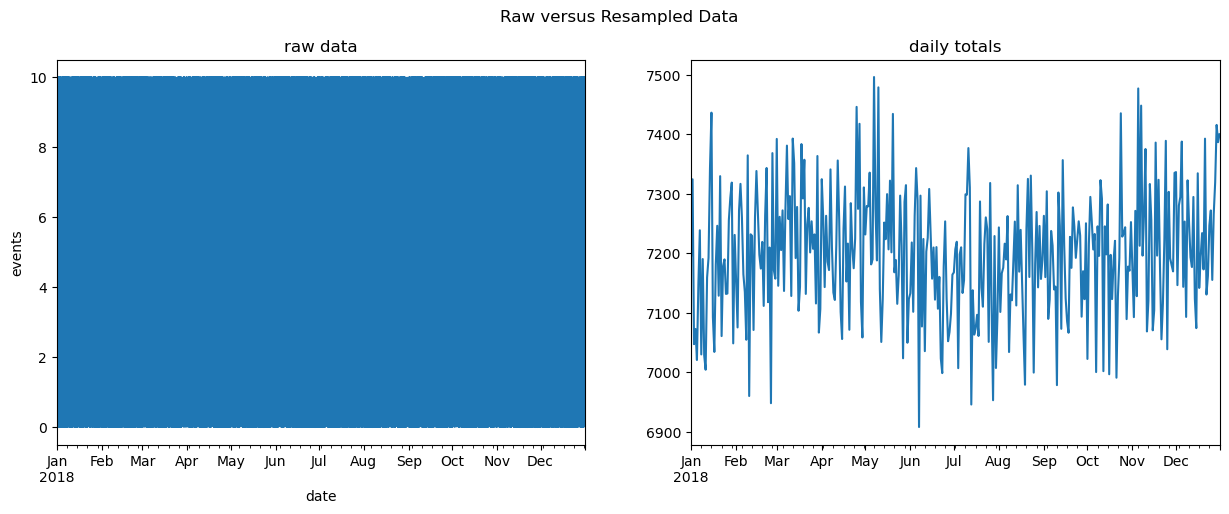

<Figure size 640x480 with 0 Axes>

In [245]:
# Then we will look at the plot at the minute level and at the daily aggregated level (summed)
np.random.seed(0)
index = pd.date_range('2018-01-01', freq='T', periods=365*24*60)
raw = pd.DataFrame(np.random.uniform(0, 10, size=index.shape[0]), index=index)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
raw.plot(legend=False, ax=axes[0], title='raw data')
raw.resample('1D').sum().plot(legend=False, ax=axes[1], title='daily totals')

for ax in axes:
    ax.set_xlabel('date')
    ax.set_ylabel('events')
    plt.suptitle('Raw versus Resampled Data')
    plt.show()


In [247]:
# The plot on the left has so much data we can't see anything. 
# However, when we aggregate to the daily totals, we see the data. 
# We can alter the granularity of the data we are working with using resampling.

In [248]:
# Recall our minute-by-minute stock data:
stock_data_per_minute.head()

,open,high,low,close,volume
date,,,,,
2019-05-20 09:30:00,181.62,181.62,181.62,181.62,159049.00
2019-05-20 09:31:00,182.61,182.61,182.61,182.61,468017.00
2019-05-20 09:32:00,182.75,182.75,182.75,182.75,97258.00
2019-05-20 09:33:00,182.95,182.95,182.95,182.95,43961.00
2019-05-20 09:34:00,183.06,183.06,183.06,183.06,79562.00


In [249]:
# We can resample this to get to a daily frequency
stock_data_per_minute.resample('1D').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'})

,open,high,low,close,volume
date,,,,,
2019-05-20,181.62,184.18,181.62,182.72,10044838.00
2019-05-21,184.53,185.58,183.97,184.82,7198405.00
2019-05-22,184.81,186.56,184.01,185.32,8412433.00
2019-05-23,182.50,183.73,179.76,180.87,12479171.00
2019-05-24,182.33,183.52,181.04,181.06,7686030.00


In [255]:
# We can downsample to quarterly data:
fb.drop(columns='trading_volume').resample('QE').mean()

,open,high,low,close,volume
date,,,,,
2018-03-31,179.47,181.79,177.04,179.55,32926396.70
2018-06-30,180.37,182.28,178.60,180.70,24055317.75
2018-09-30,180.81,182.89,178.96,181.03,27019824.76
2018-12-31,145.27,147.62,142.72,144.87,26974331.73


In [261]:
# We can also use apply(). 
# Here, we show the quarterly change from start to end
fb.drop(columns='trading_volume').resample('QE').apply(lambda x: x.last('1D').values - x.first('1D').values)

C:\Users\Kyle\AppData\Local\Temp\ipykernel_10200\2465735497.py:3: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  fb.drop(columns='trading_volume').resample('QE').apply(lambda x: x.last('1D').values - x.first('1D').values)
C:\Users\Kyle\AppData\Local\Temp\ipykernel_10200\2465735497.py:3: FutureWarning: first is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  fb.drop(columns='trading_volume').resample('QE').apply(lambda x: x.last('1D').values - x.first('1D').values)
C:\Users\Kyle\AppData\Local\Temp\ipykernel_10200\2465735497.py:3: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  fb.drop(columns='trading_volume').resample('QE').apply(lambda x: x.last('1D').values - x.first('1D').values)
C:\Users\Kyle\AppData\Local\Temp\ipykernel_10200\2465735497.py:3: FutureWarning: fir

date
2018-03-31    [[-22.53, -20.160000000000025, -23.41000000000...
2018-06-30    [[39.50999999999999, 38.399700000000024, 39.84...
2018-09-30    [[-25.039999999999992, -28.659999999999997, -2...
2018-12-31    [[-28.580000000000013, -31.24000000000001, -31...
Freq: QE-DEC, dtype: object

In [263]:
# Consider the following melted stock data by the minute. We don't see the OHLC data directly
melted_stock_data = pd.read_csv('data/melted_stock_data.csv', index_col='date', parse_dates=True)
melted_stock_data.head()

,price
date,
2019-05-20 09:30:00,181.62
2019-05-20 09:31:00,182.61
2019-05-20 09:32:00,182.75
2019-05-20 09:33:00,182.95
2019-05-20 09:34:00,183.06


In [264]:
# We can use the ohlc() method after resampling to recover the OHLC columns
melted_stock_data.resample('1D').ohlc()['price']

,open,high,low,close
date,,,,
2019-05-20,181.62,184.18,181.62,182.72
2019-05-21,184.53,185.58,183.97,184.82
2019-05-22,184.81,186.56,184.01,185.32
2019-05-23,182.50,183.73,179.76,180.87
2019-05-24,182.33,183.52,181.04,181.06


In [266]:
# Alternatively, we can upsample to increase the granularity. 
# Note this will introduce NaN values
fb.resample('6h').asfreq().head()

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02 00:00:00,177.68,181.58,177.55,181.42,18151903.00,low
2018-01-02 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03 00:00:00,181.88,184.78,181.33,184.67,16886563.00,low


In [269]:
# There are many ways to handle these NaN values. We can forward-fill with pad()
fb.resample('6h').pad().head()

AttributeError: 'DatetimeIndexResampler' object has no attribute 'pad'

In [271]:
# .pad() is deprecated and replaced with .ffill
fb.resample('6h').ffill().head()

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02 00:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 06:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 12:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 18:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-03 00:00:00,181.88,184.78,181.33,184.67,16886563,low


In [273]:
# We can specify a specific value or a method with fillna()
fb.resample('6h').fillna('nearest').head()

C:\Users\Kyle\AppData\Local\Temp\ipykernel_10200\11473396.py:2: FutureWarning: DatetimeIndexResampler.fillna is deprecated and will be removed in a future version. Use obj.ffill(), obj.bfill(), or obj.nearest() instead.
  fb.resample('6h').fillna('nearest').head()


,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02 00:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 06:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 12:00:00,181.88,184.78,181.33,184.67,16886563,low
2018-01-02 18:00:00,181.88,184.78,181.33,184.67,16886563,low
2018-01-03 00:00:00,181.88,184.78,181.33,184.67,16886563,low


In [275]:
# We can use asfreq() and assign() to specify the action per column
fb.resample('6h').asfreq().assign(
    volume=lambda x: x.volume.fillna(0), # put 0 when market is closed
    close=lambda x: x.close.fillna(method='ffill'), # carry forward
    # take the closing price if these aren't available
    open=lambda x: np.where(x.open.isnull(), x.close, x.open),
    high=lambda x: np.where(x.high.isnull(), x.close, x.high),
    low=lambda x: np.where(x.low.isnull(), x.close, x.low)
).head()

C:\Users\Kyle\AppData\Local\Temp\ipykernel_10200\3599832371.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close=lambda x: x.close.fillna(method='ffill'), # carry forward


,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02 00:00:00,177.68,181.58,177.55,181.42,18151903.00,low
2018-01-02 06:00:00,181.42,181.42,181.42,181.42,0.00,NaN
2018-01-02 12:00:00,181.42,181.42,181.42,181.42,0.00,NaN
2018-01-02 18:00:00,181.42,181.42,181.42,181.42,0.00,NaN
2018-01-03 00:00:00,181.88,184.78,181.33,184.67,16886563.00,low


In [276]:
# Merging

In [277]:
# We saw merging examples the querying_and_merging notebook. 
# However, they all matched based on keys. 
# With time series, it is possible that they are so granular that we never have the same time for multiple entries

In [278]:
import sqlite3

In [279]:
with sqlite3.connect('data/stocks.db') as connection:
    fb_prices = pd.read_sql('SELECT * FROM fb_prices', connection,
                            index_col='date', parse_dates=['date'])
    aapl_prices = pd.read_sql('SELECT * FROM aapl_prices', connection,
                              index_col='date', parse_dates=['date'])

In [280]:
# The Facebook prices are at the minute granularity
fb_prices.index.second.unique()

Index([0], dtype='int32', name='date')

In [281]:
# However, the Apple prices have information for the second
aapl_prices.index.second.unique()

Index([ 0, 52, 36, 34, 55, 35,  7, 12, 59, 17,  5, 20, 26, 23, 54, 49, 19, 53,
       11, 22, 13, 21, 10, 46, 42, 38, 33, 18, 16,  9, 56, 39,  2, 50, 31, 58,
       48, 24, 29,  6, 47, 51, 40,  3, 15, 14, 25,  4, 43,  8, 32, 27, 30, 45,
        1, 44, 57, 41, 37, 28],
      dtype='int32', name='date')

In [282]:
# We can perform an asof merge to try to line these up the best we can. 
# We specify how to handle the mismatch with the direction and tolerance parameters. 
# We will fill in with the direction of nearest and a tolerance of 30 seconds. 
# This will place the Apple data with the minute that it is closest to, so 93152 will go with 932 and 93707 will go with 937.

In [283]:
# Since the times are on the index, we pass left_index and right_index, as we did with merges earlier this chapter
pd.merge_asof(
    fb_prices, aapl_prices,
    left_index=True, right_index=True, # datetimes are in the index
    # merge with nearest minute
    direction='nearest', tolerance=pd.Timedelta(30, unit='s')
).head()

,FB,AAPL
date,,
2019-05-20 09:30:00,181.62,183.52
2019-05-20 09:31:00,182.61,NaN
2019-05-20 09:32:00,182.75,182.87
2019-05-20 09:33:00,182.95,182.50
2019-05-20 09:34:00,183.06,182.11


In [284]:
# If we don't want to lose the seconds information with the Apple data, we can use pd.merge_ordered() instead,
# which will interleave the two. 
# Note this is an outer join by default ( how parameter). 
# The only catch here is that we need to reset the index in order to join on it
pd.merge_ordered(fb_prices.reset_index(), aapl_prices.reset_index()).set_index('date').head()

,FB,AAPL
date,,
2019-05-20 09:30:00,181.62,183.52
2019-05-20 09:31:00,182.61,NaN
2019-05-20 09:31:52,NaN,182.87
2019-05-20 09:32:00,182.75,NaN
2019-05-20 09:32:36,NaN,182.50


In [285]:
# We can pass a fill_method to handle NaN values
pd.merge_ordered(fb_prices.reset_index(), aapl_prices.reset_index(),fill_method='ffill').set_index('date').head()

,FB,AAPL
date,,
2019-05-20 09:30:00,181.62,183.52
2019-05-20 09:31:00,182.61,183.52
2019-05-20 09:31:52,182.61,182.87
2019-05-20 09:32:00,182.75,182.87
2019-05-20 09:32:36,182.75,182.50


# Data Analysis

In [287]:
# Weather Data Collection

This part is just about web scraping using API and transferring the information that we scraped into a dataframe. The data of the dataframe was attainable by using the given parameters in their website, which made the process easier since we can specify what we want to obtain rather than the usual line searching in html.

In [288]:
# Querying and Merging

The import takeaway that I realized here is how I can simplify my life by using query instead of boolean masking, and how merging works (we specify a column as an identifier of the union of the two dataset). The dataframes that was shown was the result of the different options of merging the weather data and the stations data.

In [289]:
# Dataframe Operations

First, the first few dataframes was the result of using dataframe operations (.sum(), .sub(). .mean(), .std()). We made new columns for the fb dataset that calculates for an specific value using the already existing columns.
Second, we modified how the intervals of the data are shown by binning and and thresholds.

In [290]:
# Aggregations

The output dataframes are the results of summarizing the data either by agg() or groupby(). Basically, we aggregate depending on what we need either by sum, mean, percentage, and other things that I have yet to explore.

In [292]:
# Time Series

In this part, we transform and analyze the dataframes after making the as the index so that we can transform and analyze a sequence of data points in a specific point of time.

I also made some adjustments and modification in the syntax used for the procedure since some of them are deprecated and no longer functions properly.

# Supplementary

Using the CSV files provided and what we have learned so far in this module complete the following exercises:

1.With the earthquakes.csv file, select all the earthquakes in Japan with a magType of mb and a magnitude of 4.9 or greater.

In [293]:
import pandas as pd
earthquakes = pd.read_csv('data/earthquakes.csv')

In [294]:
earthquakes.head()

,mag,magType,time,place,tsunami,parsed_place
0,1.35,ml,1539475168010,"9km NE of Aguanga, CA",0,California
1,1.29,ml,1539475129610,"9km NE of Aguanga, CA",0,California
2,3.42,ml,1539475062610,"8km NE of Aguanga, CA",0,California
3,0.44,ml,1539474978070,"9km NE of Aguanga, CA",0,California
4,2.16,md,1539474716050,"10km NW of Avenal, CA",0,California


In [307]:
# I will use query to filter the required
earthquakes.query('magType == "mb" & mag >= 4.9').head().sort_values('mag')

,mag,magType,time,place,tsunami,parsed_place
229,4.90,mb,1539389546300,"193km N of Qulansiyah, Yemen",0,Yemen
248,4.90,mb,1539382925190,"151km S of Severo-Kuril'sk, Russia",0,Russia
258,5.10,mb,1539380306940,"236km NNW of Kuril'sk, Russia",0,Russia
391,5.10,mb,1539337221080,Pacific-Antarctic Ridge,0,Pacific-Antarctic Ridge
227,5.20,mb,1539389603790,"15km WSW of Pisco, Peru",0,Peru


2.Create bins for each full number of magnitude (for example, the first bin is 0-1, the second is 1-2, and so on) with a magType of ml and count how many are in each bin.

In [371]:
label = ['m1', 'm2', 'm3', 'm4', 'm5'] # For labels
earthquakes_binned = pd.cut(earthquakes.mag, bins = 5, labels = label)

In [372]:
# prints the rows of data in each bins
print([earthquakes[earthquakes_binned == i].shape[0] for i in label])

[1516, 6162, 966, 664, 23]


3.Using the faang.csv file, group by the ticker and resample to monthly frequency. Make the following aggregations
* Mean of the opening price
* Maximum of the high price
* Minimum of the low price
* Mean of the closing price
* Sum of the volume traded

In [513]:
# I will use the faang.csv from module 7
faang = pd.read_csv('data/faang-Copy1.csv')

In [370]:
faang.head()

,date,open,high,low,close,volume,ticker
0,2018-01-02,166.93,169.03,166.04,168.99,25555934,AAPL
1,2018-01-03,169.25,171.23,168.69,168.96,29517899,AAPL
2,2018-01-04,169.26,170.17,168.81,169.74,22434597,AAPL
3,2018-01-05,170.14,172.04,169.76,171.68,23660018,AAPL
4,2018-01-08,171.04,172.27,170.63,171.04,20567766,AAPL


In [380]:
# Make date column a proper datetime
faang.date = pd.to_datetime(faang.date)

In [382]:
# Make date an index
faang.set_index('date', inplace = True)

In [386]:
# Group by ticker and resample to monthly and aggregate to get the necessary requirements
faang.groupby('ticker', observed = False).resample('ME').agg({
    'open': 'mean', 
    'high': 'max', 
    'low': 'min', 
    'close': 'mean', 
    'volume': 'sum'})

open    high     low   close     volume
ticker date                                                 
AAPL   2018-01-31  170.71  176.68  161.57  170.70  659679440
       2018-02-28  164.56  177.91  147.99  164.92  927894473
       2018-03-31  172.42  180.75  162.47  171.88  713727447
       2018-04-30  167.33  176.25  158.22  167.29  666360147
       2018-05-31  182.64  187.93  162.79  183.21  620976206
       2018-06-30  186.61  192.02  178.71  186.51  527624365
       2018-07-31  188.07  193.76  181.37  188.18  393843881
       2018-08-31  210.46  227.10  195.10  211.48  700318837
       2018-09-30  220.61  227.89  213.64  220.36  678972040
       2018-10-31  219.49  231.66  204.50  219.14  789748068
       2018-11-30  190.83  220.64  169.53  190.25  961321947
       2018-12-31  164.54  184.15  145.96  163.56  898917007
AMZN   2018-01-31 1301.38 1472.58 1170.51 1309.01   96371290
       2018-02-28 1447.11 1528.70 1265.93 1442.36  137784020
       2018-03-31 1542.16 1617.54 1365.20 1540.37  130400151
       2018-04-30 1475.84 1638.10 1352.88 1468.22  129945743
       2018-05-31 1590.47 1635.00 1546.02 1594.90   71615299
       2018-06-30 1699.09 1763.10 1635.09 1698.82   85941510
       2018-07-31 1786.31 1880.05 1678.06 1784.65   97629820
       2018-08-31 1891.96 2025.57 1776.02 1897.85   96575676
       2018-09-30 1969.24 2050.50 1865.00 1966.08   94445693
       2018-10-31 1799.63 2033.19 1476.36 1782.06  183228552
       2018-11-30 1622.32 1784.00 1420.00 1625.48  139290208
       2018-12-31 1572.92 1778.34 1307.00 1559.44  154812304
FB     2018-01-31  184.36  190.66  175.80  184.96  495655736
       2018-02-28  180.72  195.32  167.18  180.27  516621991
       2018-03-31  173.45  186.10  149.02  173.49  996232472
       2018-04-30  164.16  177.10  150.51  163.81  751130388
       2018-05-31  181.91  192.72  170.23  182.93  401144183
       2018-06-30  194.97  203.55  186.43  195.27  387265765
       2018-07-31  199.33  218.62  166.56  199.97  652763259
       2018-08-31  177.60  188.30  170.27  177.49  549016789
       2018-09-30  164.23  173.89  158.87  164.38  500468912
       2018-10-31  154.87  165.88  139.03  154.19  622446235
       2018-11-30  141.76  154.13  126.85  141.64  518150415
       2018-12-31  137.53  147.19  123.02  137.16  558786249
GOOG   2018-01-31 1127.20 1186.89 1045.23 1130.77   28738485
       2018-02-28 1088.63 1174.00  992.56 1088.21   42384105
       2018-03-31 1096.11 1177.05  980.64 1091.49   45430049
       2018-04-30 1038.42 1094.16  990.37 1035.70   41773275
       2018-05-31 1064.02 1110.75 1006.29 1069.28   31849196
       2018-06-30 1136.40 1186.29 1096.01 1137.63   32103642
       2018-07-31 1183.46 1273.89 1093.80 1187.59   31953386
       2018-08-31 1226.16 1256.50 1188.24 1225.67   28820379
       2018-09-30 1176.88 1212.99 1146.91 1175.81   28863199
       2018-10-31 1116.08 1209.96  995.83 1110.94   48496167
       2018-11-30 1054.97 1095.57  996.02 1056.16   36735570
       2018-12-31 1042.62 1124.65  970.11 1037.42   40256461
NFLX   2018-01-31  231.27  286.81  195.42  232.91  238377533
       2018-02-28  270.87  297.36  236.11  271.44  184585819
       2018-03-31  312.71  333.98  275.90  312.23  263449491
       2018-04-30  309.13  338.82  271.22  307.47  262064417
       2018-05-31  329.78  356.10  305.73  331.54  142051114
       2018-06-30  384.56  423.21  352.82  384.13  244032001
       2018-07-31  380.97  419.77  328.00  381.52  305487432
       2018-08-31  345.41  376.81  310.93  346.26  213144082
       2018-09-30  363.33  383.20  335.83  362.64  170832156
       2018-10-31  340.03  386.80  271.21  335.45  363589920
       2018-11-30  290.64  332.05  250.00  290.34  257126498
       2018-12-31  266.31  298.72  231.23  265.30  234304628

4.Build a crosstab with the earthquake data between the tsunami column and the magType column. Rather than showing the frequency count, show the maximum magnitude that was observed for each combination. Put the magType along the columns.

In [407]:
pd.crosstab(
    index = earthquakes.tsunami,
    columns = earthquakes.magType,
    values = earthquakes.mag,
    aggfunc = 'max'
)

magType,mb,mb_lg,md,mh,ml,ms_20,mw,mwb,mwr,mww
tsunami,,,,,,,,,,
0,5.60,3.50,4.11,1.10,4.20,NaN,3.83,5.80,4.80,6.00
1,6.10,NaN,NaN,NaN,5.10,5.70,4.41,NaN,NaN,7.50


5.Calculate the rolling 60-day aggregations of OHLC data by ticker for the FAANG data. Use the same aggregations as exercise no. 3.

In [415]:
# I will sort the date index first
faang.sort_index(inplace = True)

In [421]:
# Then do the rolling
faang.groupby('ticker', observed = False).rolling('60D').agg({
    'open': 'mean', 
    'high': 'max', 
    'low': 'min', 
    'close': 'mean', 
    'volume': 'sum'})

open   high    low  close       volume
ticker date                                               
AAPL   2018-01-02 166.93 169.03 166.04 168.99  25555934.00
       2018-01-03 168.09 171.23 166.04 168.97  55073833.00
       2018-01-04 168.48 171.23 166.04 169.23  77508430.00
       2018-01-05 168.90 172.04 166.04 169.84 101168448.00
       2018-01-08 169.32 172.27 166.04 170.08 121736214.00
...                  ...    ...    ...    ...          ...
NFLX   2018-12-24 283.51 332.05 233.68 281.93 525657894.00
       2018-12-26 281.84 332.05 231.23 280.78 520444588.00
       2018-12-27 281.07 332.05 231.23 280.16 532679805.00
       2018-12-28 279.92 332.05 231.23 279.46 521968250.00
       2018-12-31 278.43 332.05 231.23 277.45 476309676.00

[1255 rows x 5 columns]

6.Create a pivot table of the FAANG data that compares the stocks. Put the ticker in the rows and show the averages of the OHLC and volume traded data.

In [426]:
faang.pivot_table(index = 'ticker') # aggfunc = 'mean' is default

,close,high,low,open,volume
ticker,,,,,
AAPL,186.99,188.91,185.14,187.04,34021449.63
AMZN,1641.73,1662.84,1619.84,1644.07,5649562.81
FB,171.51,173.62,169.30,171.45,27687977.67
GOOG,1113.23,1125.78,1101.00,1113.55,1742645.08
NFLX,319.29,325.22,313.19,319.62,11470299.17


7.Calculate the Z-scores for each numeric column of Netflix's data (ticker is NFLX) using apply().

In [435]:
# Z-score formula: (x − x̅ )/σ
# I will filter NFLX ticker using query and locate the columns needed
# Then do the apply
faang.query('ticker == "NFLX"'
           ).loc[:, ['close', 'high', 'low', 'open', 'volume']
].apply(lambda x: x.sub(x.mean()).div(x.std())).describe().T

,count,mean,std,min,25%,50%,75%,max
close,251.00,-0.00,1.00,-2.42,-0.71,0.04,0.76,2.04
high,251.00,0.00,1.00,-2.52,-0.71,0.04,0.77,1.99
low,251.00,-0.00,1.00,-2.41,-0.77,0.07,0.75,2.04
open,251.00,0.00,1.00,-2.50,-0.72,0.06,0.77,2.06
volume,251.00,0.00,1.00,-1.39,-0.62,-0.18,0.39,8.28


8.Add event descriptions
* Create a dataframe with the following three columns: ticker, date, and event. The columns should have the following values:
  * ticker: 'FB'
  * date: ['2018-07-25', '2018-03-19', '2018-03-20']
  * event: ['Disappointing user growth announced after close.', 'Cambridge Analytica story', 'FTC investigation']
  * Set the index to ['date', 'ticker']
  * Merge this data with the FAANG data using an outer join

In [439]:
# Setting up the variables
ticker = ['FB'] * 3
date = ['2018-07-25', '2018-03-19', '2018-03-20']
event = ['Disappointing user growth announced after close.', 'Cambridge Analytica story', 'FTC investigation']

In [440]:
# Making the dataframe
fb_frame = pd.DataFrame({'ticker': ticker, 'date': date, 'event': event})

In [441]:
fb_frame.head()

,ticker,date,event
0,FB,2018-07-25,Disappointing user growth announced after close.
1,FB,2018-03-19,Cambridge Analytica story
2,FB,2018-03-20,FTC investigation


In [500]:
faang.head()

,date,open,high,low,close,volume,ticker
0,2018-01-02,166.93,169.03,166.04,168.99,25555934,AAPL
1,2018-01-02,177.68,181.58,177.55,181.42,18151903,FB
2,2018-01-02,1048.34,1066.94,1045.23,1065.00,1237564,GOOG
3,2018-01-02,1172.00,1190.00,1170.51,1189.01,2694494,AMZN
4,2018-01-02,196.10,201.65,195.42,201.07,10966889,NFLX


In [521]:
# I should convert the date to string (if in datetime) because merge doesn't allow for date on identifier
faang.date = faang.date.astype('object')

In [522]:
# Merging the data with the FAANG with outer join
faang_merge_event = faang.merge(fb_frame, how = 'outer', on = ['date','ticker'])

In [530]:
# I can now fix the date again
faang.date = pd.to_datetime(faang.date)
faang_merge_event.date = pd.to_datetime(faang_merge_event.date)

In [531]:
faang_merge_event.sort_values('event').head()

,date,open,high,low,close,volume,ticker,event
262,2018-03-19,177.01,177.17,170.06,172.56,88140060,FB,Cambridge Analytica story
707,2018-07-25,215.72,218.62,214.27,217.50,64592585,FB,Disappointing user growth announced after close.
267,2018-03-20,167.47,170.20,161.95,168.15,129851768,FB,FTC investigation
0,2018-01-02,166.93,169.03,166.04,168.99,25555934,AAPL,NaN
1,2018-01-02,1172.00,1190.00,1170.51,1189.01,2694494,AMZN,NaN


9.Use the transform() method on the FAANG data to represent all the values in terms of the first date in the data. To do so, divide all the values for each ticker by the values for the first date in the data for that ticker. This is referred to as an index, and the data for the first date is the base (https://ec.europa.eu/eurostat/statistics-explained/index.php/Beginners:Statisticalconcept-Indexandbaseyear). When data is in this format, we can easily see growth over time. Hint: transform() can take a function name.

In [548]:
# Set the date as the index (again) as well as the tickers
faang_transform = faang.set_index(['date', 'ticker'])

In [549]:
# Group all values by tickers, with the said instruction as the aggregation.
faang_transform.groupby(['ticker'])[['open','high','low','close','volume']].transform(lambda x: x.div(x.iloc[0]))

,,open,high,low,close,volume
date,ticker,,,,,
2018-01-02,AAPL,1.00,1.00,1.00,1.00,1.00
2018-01-03,AAPL,1.01,1.01,1.02,1.00,1.16
2018-01-04,AAPL,1.01,1.01,1.02,1.00,0.88
2018-01-05,AAPL,1.02,1.02,1.02,1.02,0.93
2018-01-08,AAPL,1.02,1.02,1.03,1.01,0.80
...,...,...,...,...,...,...
2018-12-24,NFLX,1.23,1.24,1.20,1.16,0.87
2018-12-26,NFLX,1.19,1.26,1.18,1.26,1.31
2018-12-27,NFLX,1.28,1.27,1.23,1.27,1.12
